In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from tensorflow.python.ops import rnn, rnn_cell
import random

# Hyperparameters

In [2]:
train_length = 1000
test_length = 1500

discount_rate = 0.997
rnn_size = 10

sampling_rate = 200
striding = 100

In [3]:
def downgrade_and_feature(array):
    nchannels = array.shape[0]
    data_length = array.shape[1]
    
    temp = np.zeros(data_length)
    
    for j in range(data_length):
        for i in range(nchannels):
            temp[j] += array[i][j]
        temp[j]/=nchannels
    
    reduced_length = int(data_length/striding)

    averages = np.zeros(reduced_length, dtype = np.float32)   
    variations = np.zeros(reduced_length, dtype = np.float32)
    
    for i in range(reduced_length):
        averages[i] = np.average(temp[striding*i:striding*(i+1)])
        variations[i] = np.var(temp[striding*i:striding*(i+1)])
        
    return {'averages' : averages,'variations' : variations}

In [4]:
def dataload(patient_number, dataset_number):
    try :
        input_folder_path = '/home/maestroj/medical_analysis/eeg_csv'
        input_data_name = 'data{}_{}.csv'.format(patient_number,dataset_number)
        input_data_path = os.path.join(input_folder_path,input_data_name)
        input_file = open(input_data_path,'r',newline='')
        reader = csv.reader(input_file, delimiter=',')
        print("{} is loaded".format(input_data_name))
        temp = []
        for row in reader:
            temp.append(row)
        temp = np.array(temp, dtype=np.float32)
        temp = np.transpose(temp)
        return temp
    except FileNotFoundError:
        print("No such File")
        temp = []
        temp = np.array(temp)
        return temp

In [5]:
def normal_data_load(patient_number, iswakeup=0):
    try :
        input_folder_path = '/home/maestroj/medical_analysis/eeg_normal'
        input_data_name = 'data{}xs.csv'.format(patient_number)
        if iswakeup == 1:
            input_data_name = 'data{}w.csv'.format(patient_number)
        input_data_path = os.path.join(input_folder_path,input_data_name)
        input_file = open(input_data_path,'r',newline='')
        reader = csv.reader(input_file, delimiter=',')
        print("{} is loaded".format(input_data_name))
        temp = []
        for row in reader:
            temp.append(row)
        temp = np.array(temp, dtype=np.float32)
        temp = np.transpose(temp)
        return temp
    except FileNotFoundError:
        print("No such File")
        temp = []
        temp = np.array(temp)
        return temp

In [6]:
def time_axis_maker(array, sec_per_cell,init = 0):
    final = init + sec_per_cell*(len(array)-1)
    return np.linspace(init,final,len(array))

# Onset-time data

In [7]:
def seizure_time_parser(onset_times,patient_number,data_set_number):
    temp = str(onset_times[patient_number-1][data_set_number])
    curr_onset_time = []
    while temp.find('/')!=-1:
        curr_onset_time.append(int(temp[0:temp.find('/')]))
        temp=temp[temp.find('/')+1:]
    curr_onset_time.append(int(float(temp)))
    curr_onset_time=np.array(curr_onset_time)
    return curr_onset_time

In [8]:
seizure_file = open('seizure_times.csv','r',newline='')
reader = csv.reader(seizure_file,delimiter=',')
onset_times_temp=[]

for row in reader:
    onset_times_temp.append(row)
    
onset_times = []
total_patient = len(onset_times_temp)
event_number = np.zeros(total_patient,dtype=np.int32)
#number of events of (i+1) patient = event_number[i]

for i in range(total_patient):
    event_number[i] = len(onset_times_temp[i])-1

for p in range(total_patient):
    temp = []
    for d in range(event_number[p]):
        temp.append(seizure_time_parser(onset_times_temp,p+1,d+1))
    onset_times.append(temp)

In [9]:
print("The number of datasets of patients")
print(event_number)
print("1st patient's seizure time for each data_set")
print(onset_times[0][1])
print("9th patient's seizure time for each data_set")
print(onset_times[8])

The number of datasets of patients
[ 7  7  6  3 10  1  7 13 16  8  8  5  3  6 31  8  2  4]
1st patient's seizure time for each data_set
[781]
9th patient's seizure time for each data_set
[array([200]), array([312]), array([624]), array([762]), array([752]), array([772]), array([884]), array([502]), array([ 94, 258]), array([836]), array([650]), array([636]), array([576]), array([656]), array([638]), array([706])]


In [10]:
temp = dataload(1,1)
print(temp.shape)
result = downgrade_and_feature(temp)
print(result['averages'].shape)
print(result['variations'].shape)
time = time_axis_maker(result['averages'], striding/sampling_rate)

data1_1.csv is loaded
(22, 315200)
(3152,)
(3152,)


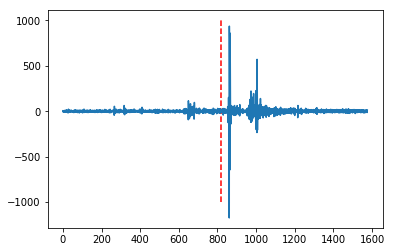

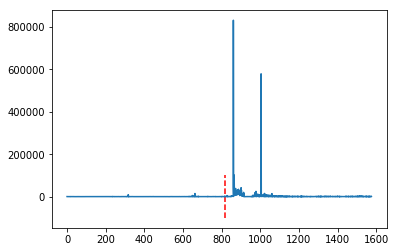

In [11]:
plt.plot(time, result['averages'])
plt.vlines(onset_times[0][0], -1000, 1000, colors='r', linestyles='--')
plt.show()

plt.plot(time, result['variations'])
plt.vlines(onset_times[0][0], -100000, 100000, colors='r', linestyles='--')
plt.show()

# Training_set

In [12]:
def train_set_generator(patient_number, dataset_number):
    temp = dataload(patient_number,dataset_number)
    if len(temp)==0:
        return
    result = downgrade_and_feature(temp)
    onset_time_temp = onset_times[patient_number-1][dataset_number-1]        

    if len(onset_time_temp) > 1:
        print("More than one onset time")
        return
    
    onset_time_temp = onset_time_temp[0]
    
    if onset_time_temp*sampling_rate/striding < train_length:
        print("Wrong input")
        return
    
    input_data = np.zeros((2,train_length))
    output_data = np.zeros(train_length)
    
    for i in range(train_length):
        if i==0:
            output_data[train_length-1] = 1
        else :
            output_data[train_length-1-i] = discount_rate*output_data[train_length-i] 

    onset_on_array = int(onset_time_temp*sampling_rate/striding)
    
    for i in range(train_length):
        input_data[0][i] = result['averages'][onset_on_array-train_length+1+i]
        input_data[1][i] = result['variations'][onset_on_array-train_length+1+i]

    return {'input' : input_data, 'output' : output_data}

In [13]:
def train_set_generator2(patient_number, iswakeup=0):
    temp = normal_data_load(patient_number,iswakeup)
    if len(temp)==0:
        return
    result = downgrade_and_feature(temp)
    original_length = len(result['averages'])
    input_data = np.zeros((2,train_length))
    output_data = np.zeros(train_length)
    for i in range(train_length):
        index = i%original_length
        input_data[0][i] = result['averages'][index]
        input_data[1][i] = result['variations'][index]
    return {'input' : input_data, 'output' : output_data}

data1_1.csv is loaded


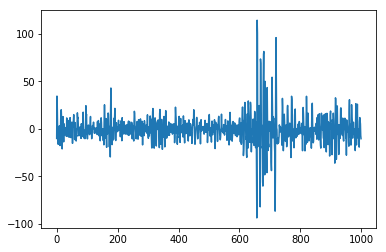

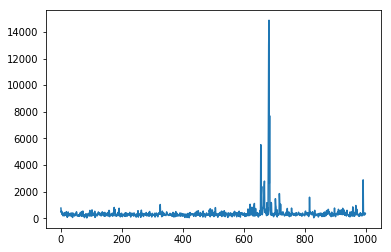

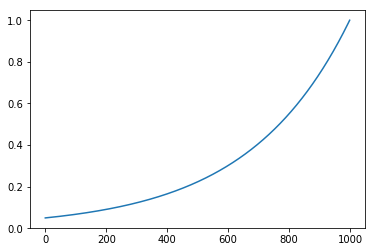

(2, 1000)
(1000,)


In [14]:
result = train_set_generator(1,1)
plt.plot(result['input'][0])
plt.show()
plt.plot(result['input'][1])
plt.show()
plt.plot(result['output'])
plt.show()
print(result['input'].shape)
print(result['output'].shape)

data1_3.csv is loaded


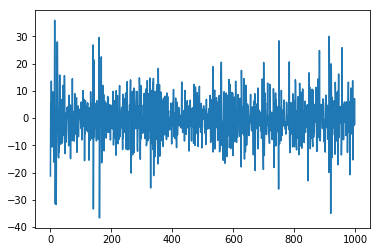

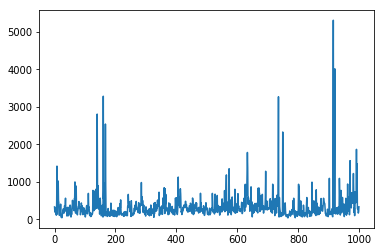

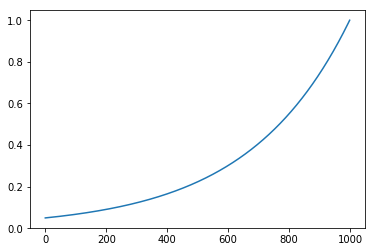

(2, 1000)
(1000,)


In [15]:
result = train_set_generator(1,3)
plt.plot(result['input'][0])
plt.show()
plt.plot(result['input'][1])
plt.show()
plt.plot(result['output'])
plt.show()
print(result['input'].shape)
print(result['output'].shape)

# Neural network

In [16]:
x = tf.placeholder(tf.float32, shape=[2,train_length])
y = tf.placeholder(tf.float32, shape=[train_length])
test_x = tf.placeholder(tf.float32, shape=[2,test_length])

rnn_tei_x = tf.transpose(test_x,[1,0])
rnn_tei_x = tf.split(0,test_length,rnn_tei_x)

rnn_tri_x = tf.transpose(x,[1,0])
rnn_tri_x = tf.split(0,train_length,rnn_tri_x)

with tf.variable_scope("rnn") as scope:
    lstm_cell = rnn_cell.LSTMCell(rnn_size)

    W = tf.Variable(tf.truncated_normal([rnn_size,1], stddev=0.01))
    b = tf.Variable(tf.constant(0.01, shape=[1]))
    
    initial_state = lstm_cell.zero_state(1, tf.float32)
    
    outputs, states = rnn.rnn(lstm_cell, inputs = rnn_tri_x, initial_state = initial_state, dtype=tf.float32)
    temp_outputs = tf.pack(outputs)
    temp_outputs = tf.reshape(temp_outputs,[-1,rnn_size])
    temp_outputs = tf.matmul(temp_outputs,W)+b
    print(temp_outputs)
    
    scope.reuse_variables()
    test_outputs, test_states = rnn.rnn(lstm_cell, inputs = rnn_tei_x, initial_state = initial_state, dtype =tf.float32)
    temp_test_outputs = tf.pack(test_outputs)
    temp_test_outputs = tf.reshape(temp_test_outputs, [-1,rnn_size])
    temp_test_outputs = tf.matmul(temp_test_outputs,W)+b
    print(temp_test_outputs)
    temp_y = tf.reshape(y, [-1,1])
    print(temp_y)
    
    


Tensor("rnn/add:0", shape=(1000, 1), dtype=float32)
Tensor("rnn/add_1:0", shape=(1500, 1), dtype=float32)
Tensor("rnn/Reshape_2:0", shape=(1000, 1), dtype=float32)


In [ ]:
cost = tf.reduce_sum(tf.square(temp_outputs-temp_y))
train = tf.train.AdamOptimizer(1e-3).minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_data_set = []
temp_train_data_set = [1,6,8,9,10,11,12,14,15,16,17,18]
train_data_set.append(temp_train_data_set)
temp_train_data_set = [1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,21]
train_data_set.append(temp_train_data_set)
temp_train_data_set = [1,8,9,10,16,17]
train_data_set.append(temp_train_data_set)
print(train_data_set)

Patient 1 and dataset 1
data1_1.csv is loaded
Before Cost = 158.87911987304688
After Cost = 135.0133056640625
No such File
Patient 1 and dataset 2
data1_2.csv is loaded
Before Cost = 125.16633605957031
After Cost = 90.92332458496094
data1w.csv is loaded
Normal 1 wake_up 1
Before Cost = 27.60037612915039
After Cost = 22.79111099243164
Patient 1 and dataset 3
data1_3.csv is loaded
Before Cost = 91.92593383789062
After Cost = 84.62519836425781
No such File
Patient 1 and dataset 4
data1_4.csv is loaded
Before Cost = 82.87574768066406
After Cost = 68.56598663330078
data1w.csv is loaded
Normal 1 wake_up 1
Before Cost = 51.02824401855469
After Cost = 35.62994384765625
Patient 1 and dataset 5
data1_5.csv is loaded
Before Cost = 77.44694519042969
After Cost = 73.35466003417969
No such File
Patient 1 and dataset 6
data1_6.csv is loaded
Before Cost = 73.22907257080078
After Cost = 63.51169204711914
data1w.csv is loaded
Normal 1 wake_up 1
Before Cost = 58.55575180053711
After Cost = 37.41357421875

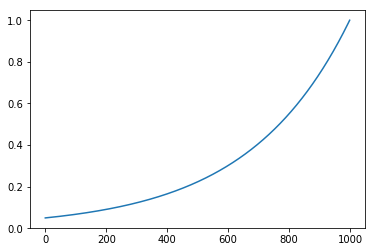

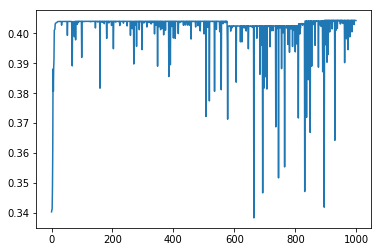

Before Cost = 73.60123443603516
After Cost = 70.06080627441406


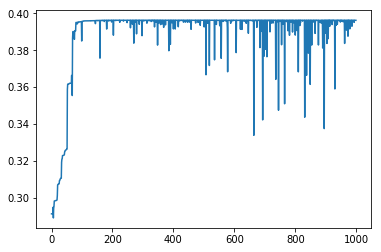

data3w.csv is loaded
Normal 3 wake_up 1


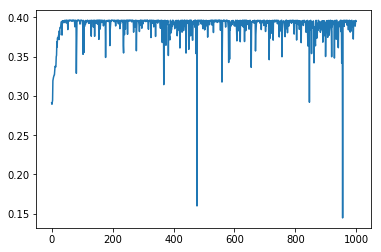

Before Cost = 151.82586669921875
After Cost = 60.06648635864258


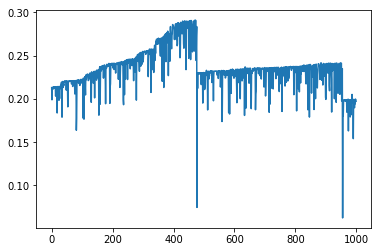

Patient 4 and dataset 1
data4_1.csv is loaded
Before Cost = 99.99392700195312
After Cost = 89.75389862060547
No such File
Patient 4 and dataset 2
data4_2.csv is loaded
Before Cost = 83.30908203125
After Cost = 66.03913879394531
data4w.csv is loaded
Normal 4 wake_up 1
Before Cost = 73.51068878173828
After Cost = 15.739971160888672
Patient 4 and dataset 3
data4_3.csv is loaded


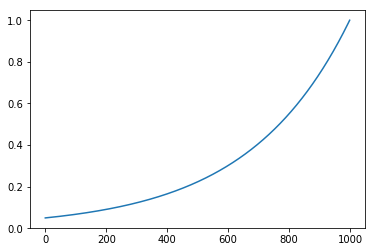

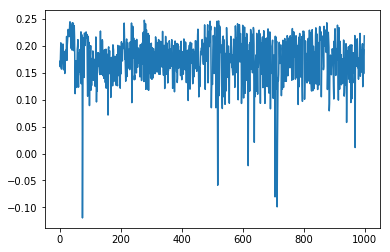

Before Cost = 88.56165313720703
After Cost = 73.34979248046875


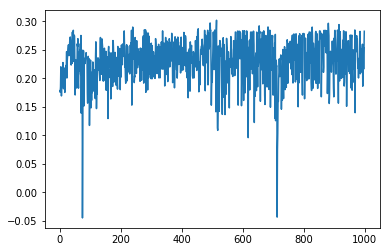

No such File
Patient 5 and dataset 2
data5_2.csv is loaded
Before Cost = 64.91513061523438
After Cost = 63.64885711669922
data5w.csv is loaded
Normal 5 wake_up 1
Before Cost = 43.51963806152344
After Cost = 24.322744369506836
Patient 5 and dataset 3
data5_3.csv is loaded
Before Cost = 85.0160903930664
After Cost = 81.55787658691406
No such File
Patient 5 and dataset 4
data5_4.csv is loaded
Before Cost = 61.065826416015625
After Cost = 55.843711853027344
data5w.csv is loaded
Normal 5 wake_up 1
Before Cost = 38.86566925048828
After Cost = 25.92548370361328
Patient 6 and dataset 1
data6_1.csv is loaded
Before Cost = 85.73435974121094
After Cost = 67.45050048828125
No such File
Patient 7 and dataset 1
data7_1.csv is loaded
Before Cost = 72.42880249023438
After Cost = 54.526397705078125
No such File
Patient 7 and dataset 2
data7_2.csv is loaded


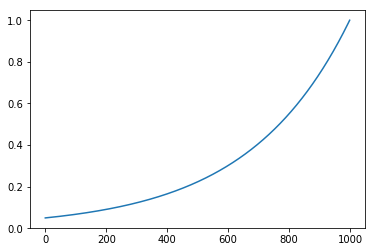

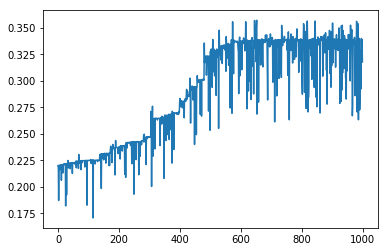

Before Cost = 51.69248962402344
After Cost = 46.53640365600586


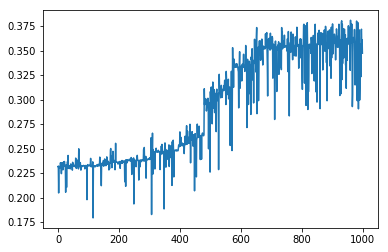

data7w.csv is loaded
Normal 7 wake_up 1


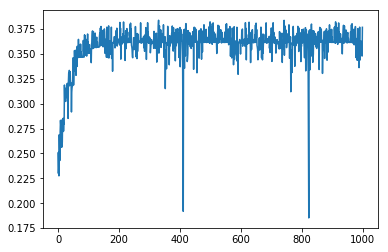

Before Cost = 128.61077880859375
After Cost = 71.51255798339844


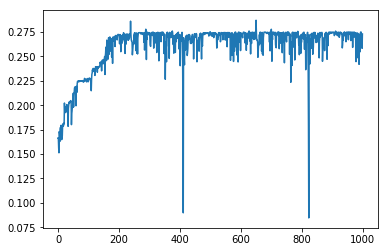

Patient 7 and dataset 3
data7_3.csv is loaded


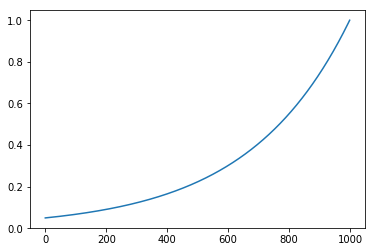

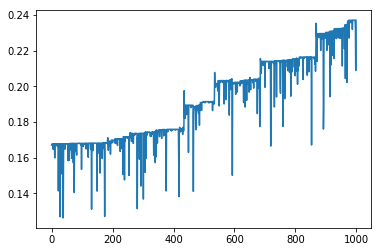

Before Cost = 71.26239013671875
After Cost = 61.92791748046875


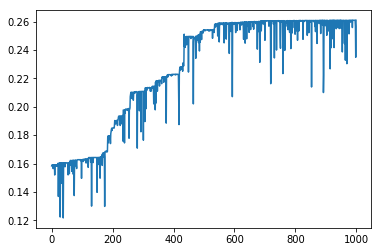

No such File
Patient 7 and dataset 4
data7_4.csv is loaded
Before Cost = 63.82249450683594
After Cost = 57.878623962402344
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 81.96884155273438
After Cost = 51.42379379272461
Patient 7 and dataset 5
data7_5.csv is loaded


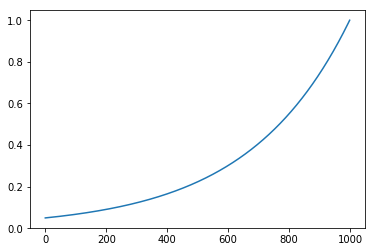

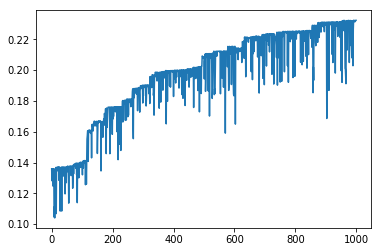

Before Cost = 70.34654235839844
After Cost = 70.70793914794922


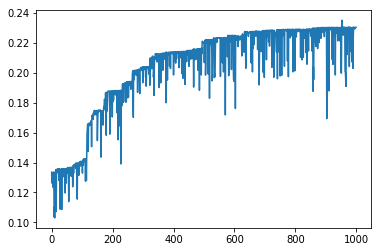

No such File
Patient 7 and dataset 6
data7_6.csv is loaded
Before Cost = 71.3901596069336
After Cost = 63.588558197021484
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 68.3612289428711
After Cost = 44.60581970214844
Patient 7 and dataset 7
data7_7.csv is loaded


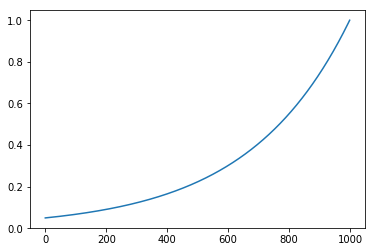

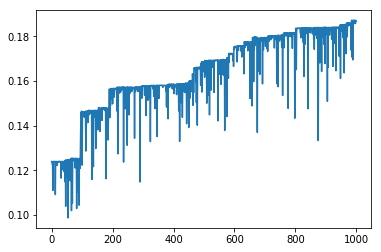

Before Cost = 82.92176055908203
After Cost = 72.34445190429688


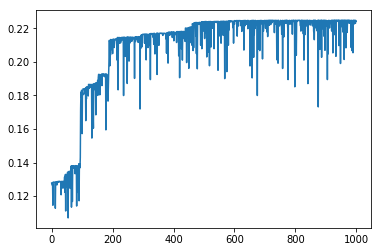

No such File
Patient 8 and dataset 1
data8_1.csv is loaded
Before Cost = 74.9255142211914
After Cost = 67.59568786621094
No such File
Patient 8 and dataset 2
data8_2.csv is loaded
Before Cost = 64.97615051269531
After Cost = 54.99585723876953
data8w.csv is loaded
Normal 8 wake_up 1
Before Cost = 28.241226196289062
After Cost = 19.818998336791992
Patient 8 and dataset 3
data8_3.csv is loaded
Before Cost = 61.41224670410156
After Cost = 59.09521484375
No such File
Patient 8 and dataset 4
data8_4.csv is loaded
Before Cost = 62.507633209228516
After Cost = 53.108116149902344
data8w.csv is loaded
Normal 8 wake_up 1
Before Cost = 29.52037811279297
After Cost = 16.929391860961914
Patient 8 and dataset 5
data8_5.csv is loaded
Before Cost = 56.819801330566406
After Cost = 53.39542770385742
No such File
Patient 8 and dataset 6
data8_6.csv is loaded
Before Cost = 86.95355224609375
After Cost = 51.673492431640625
data8w.csv is loaded
Normal 8 wake_up 1
Before Cost = 26.76675796508789
After Cost = 

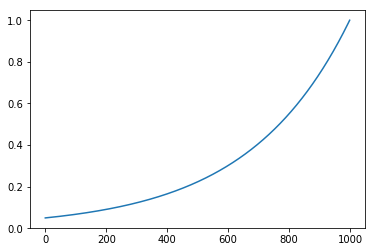

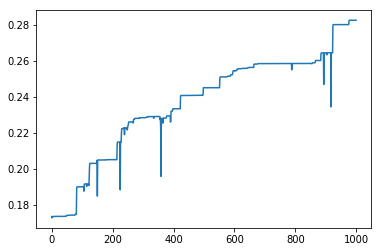

Before Cost = 60.975563049316406
After Cost = 48.9382438659668


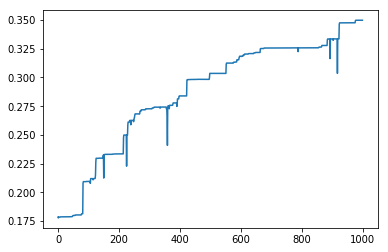

data8w.csv is loaded
Normal 8 wake_up 1


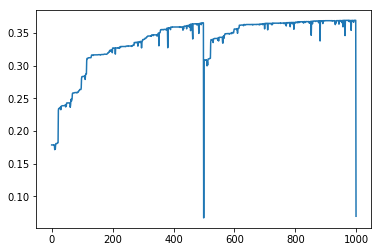

Before Cost = 115.83489990234375
After Cost = 12.182613372802734


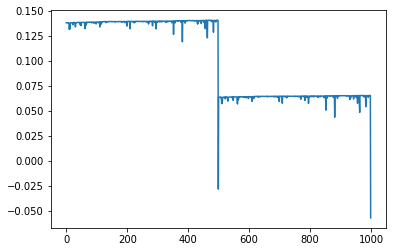

Patient 8 and dataset 11
data8_11.csv is loaded
Before Cost = 96.5584716796875
After Cost = 90.9537124633789
No such File
Patient 8 and dataset 12
data8_12.csv is loaded
Before Cost = 90.87741088867188
After Cost = 78.36371612548828
data8w.csv is loaded
Normal 8 wake_up 1
Before Cost = 30.100322723388672
After Cost = 24.568330764770508
Patient 8 and dataset 13
data8_13.csv is loaded
Before Cost = 57.72206115722656
After Cost = 43.90062713623047
No such File
Patient 9 and dataset 3
data9_3.csv is loaded
Before Cost = 66.64336395263672
After Cost = 66.09380340576172
No such File
Patient 9 and dataset 4
data9_4.csv is loaded
Before Cost = 66.69135284423828
After Cost = 65.57481384277344
data9w.csv is loaded
Normal 9 wake_up 1
Before Cost = 64.70938873291016
After Cost = 2.7225422859191895
Patient 9 and dataset 5
data9_5.csv is loaded
Before Cost = 72.48277282714844
After Cost = 61.285736083984375
No such File
Patient 9 and dataset 6
data9_6.csv is loaded
Before Cost = 63.63901138305664
Af

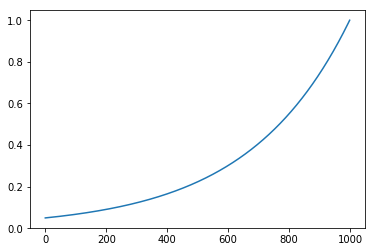

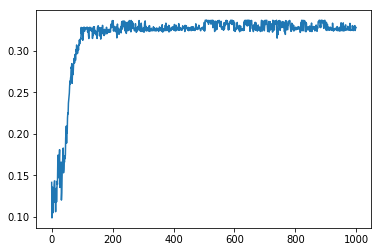

Before Cost = 61.65946960449219
After Cost = 60.294700622558594


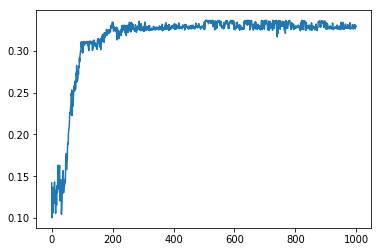

data9w.csv is loaded
Normal 9 wake_up 1


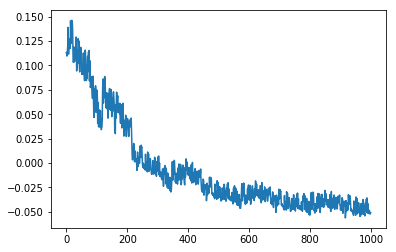

Before Cost = 2.318310022354126
After Cost = 2.2511887550354004


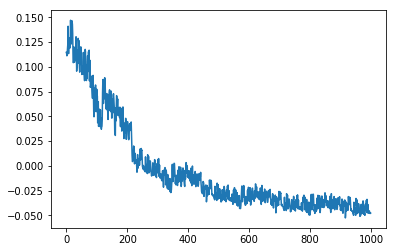

Patient 9 and dataset 11
data9_11.csv is loaded
Before Cost = 59.33059310913086
After Cost = 56.639888763427734
No such File
Patient 9 and dataset 12
data9_12.csv is loaded
Before Cost = 54.328948974609375
After Cost = 52.14177322387695
data9w.csv is loaded
Normal 9 wake_up 1
Before Cost = 2.3534343242645264
After Cost = 2.173794746398926
Patient 9 and dataset 13
data9_13.csv is loaded
Before Cost = 52.25347137451172
After Cost = 43.317657470703125
No such File
Patient 9 and dataset 14
data9_14.csv is loaded
Before Cost = 45.16902542114258
After Cost = 40.95945358276367
data9w.csv is loaded
Normal 9 wake_up 1
Before Cost = 3.1260242462158203
After Cost = 1.8374688625335693
Patient 9 and dataset 15
data9_15.csv is loaded
Before Cost = 62.58030700683594
After Cost = 38.91564178466797
No such File
Patient 9 and dataset 16
data9_16.csv is loaded


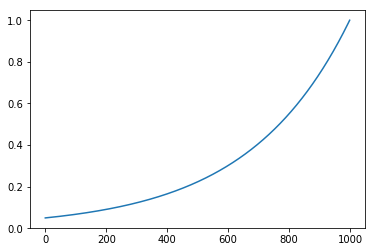

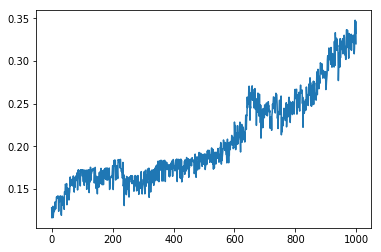

Before Cost = 54.61102294921875
After Cost = 31.251537322998047


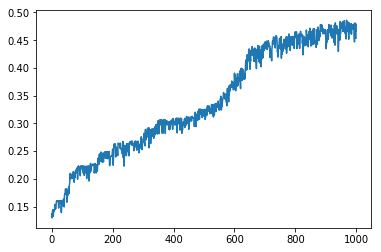

data9w.csv is loaded
Normal 9 wake_up 1


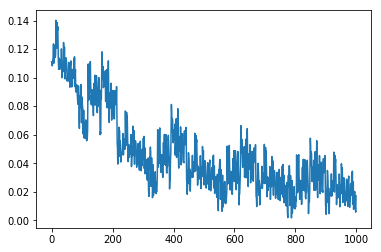

Before Cost = 3.056983709335327
After Cost = 1.6862740516662598


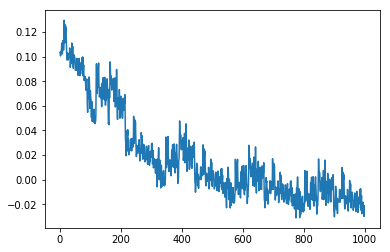

Patient 11 and dataset 1
data11_1.csv is loaded
Before Cost = 72.51557922363281
After Cost = 48.463172912597656
No such File
Patient 11 and dataset 2
data11_2.csv is loaded
Before Cost = 54.540592193603516
After Cost = 40.058712005615234
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 34.570945739746094
After Cost = 5.53494930267334
Patient 11 and dataset 3
data11_3.csv is loaded


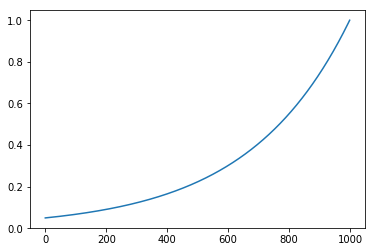

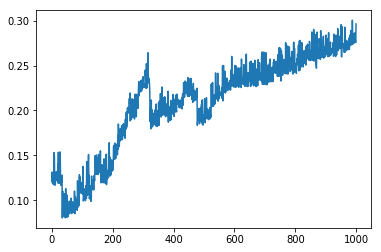

Before Cost = 58.70954132080078
After Cost = 33.6802978515625


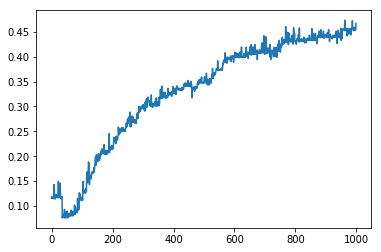

No such File
Patient 11 and dataset 4
data11_4.csv is loaded
Before Cost = 31.28058624267578
After Cost = 26.54503631591797
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 7.650757789611816
After Cost = 7.320471286773682
Patient 11 and dataset 5
data11_5.csv is loaded
Before Cost = 38.62073516845703
After Cost = 28.596965789794922
No such File
Patient 11 and dataset 6
data11_6.csv is loaded
Before Cost = 39.369285583496094
After Cost = 34.108673095703125
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 17.05531883239746
After Cost = 7.183660507202148
Patient 11 and dataset 7
data11_7.csv is loaded
Before Cost = 35.48523712158203
After Cost = 24.559223175048828
No such File
Patient 11 and dataset 8
data11_8.csv is loaded
Before Cost = 30.309730529785156
After Cost = 23.030288696289062
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 9.970491409301758
After Cost = 6.960407257080078
Patient 12 and dataset 1
data12_1.csv is loaded


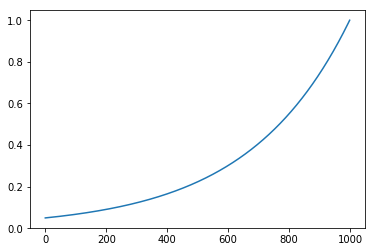

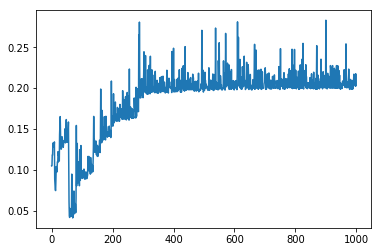

Before Cost = 74.24866485595703
After Cost = 58.372772216796875


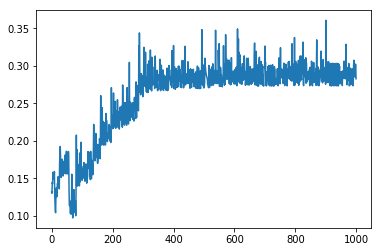

No such File
Patient 13 and dataset 1
data13_1.csv is loaded
Before Cost = 81.53279876708984
After Cost = 39.34701156616211
No such File
Patient 13 and dataset 2
data13_2.csv is loaded
Before Cost = 73.40464782714844
After Cost = 42.76502227783203
data4w.csv is loaded
Normal 4 wake_up 1
Before Cost = 10.342597007751465
After Cost = 6.043322563171387
Patient 13 and dataset 3
data13_3.csv is loaded
Before Cost = 59.29212188720703
After Cost = 38.87302780151367
No such File
Patient 14 and dataset 1
data14_1.csv is loaded
Before Cost = 89.81800842285156
After Cost = 62.61029815673828
No such File
Patient 14 and dataset 2
data14_2.csv is loaded
Before Cost = 75.7962417602539
After Cost = 64.76828002929688
data5w.csv is loaded
Normal 5 wake_up 1
Before Cost = 4.732467174530029
After Cost = 3.3099100589752197
Patient 14 and dataset 3
data14_3.csv is loaded
Before Cost = 61.853843688964844
After Cost = 61.23979949951172
No such File
Patient 14 and dataset 4
data14_4.csv is loaded
Before Cost =

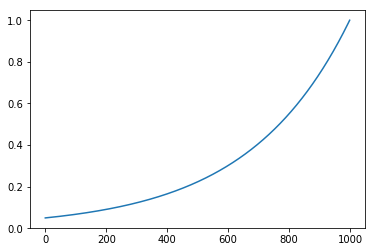

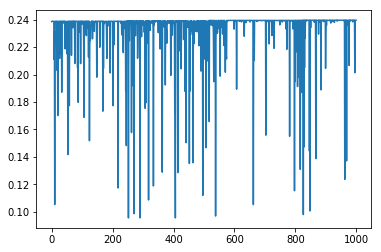

Before Cost = 73.08409881591797
After Cost = 69.71122741699219


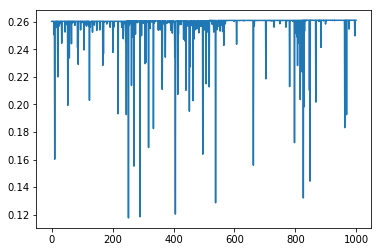

No such File
Patient 15 and dataset 30
data15_30.csv is loaded
Before Cost = 70.79417419433594
After Cost = 68.55439758300781
data6w.csv is loaded
Normal 6 wake_up 1
Before Cost = 47.093238830566406
After Cost = 18.492996215820312
Patient 16 and dataset 1
data16_1.csv is loaded
Before Cost = 98.26934814453125
After Cost = 71.3434829711914
No such File
Patient 16 and dataset 2
data16_2.csv is loaded
Before Cost = 80.48628234863281
After Cost = 66.3241195678711
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 34.97314453125
After Cost = 24.389829635620117
Patient 16 and dataset 3
data16_3.csv is loaded


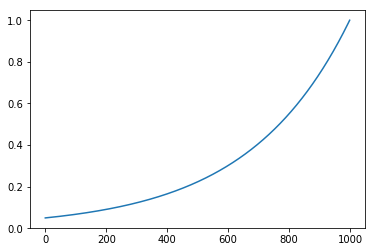

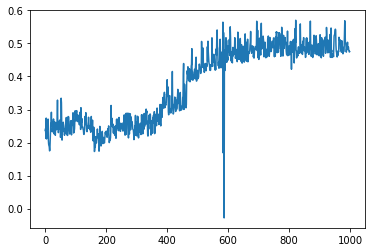

Before Cost = 35.759647369384766
After Cost = 29.24410629272461


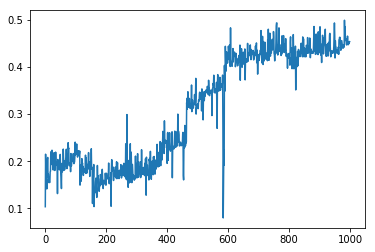

No such File
Patient 16 and dataset 4
data16_4.csv is loaded
Before Cost = 36.66960144042969
After Cost = 27.24919319152832
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 14.60262680053711
After Cost = 11.105978965759277
Patient 16 and dataset 5
data16_5.csv is loaded
Before Cost = 62.393333435058594
After Cost = 43.846168518066406
No such File
Patient 16 and dataset 6
data16_6.csv is loaded
Before Cost = 66.92827606201172
After Cost = 48.09718704223633
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 9.121810913085938
After Cost = 8.051374435424805
Patient 16 and dataset 7
data16_7.csv is loaded
Before Cost = 46.131080627441406
After Cost = 35.797935485839844
No such File
Patient 16 and dataset 8
data16_8.csv is loaded


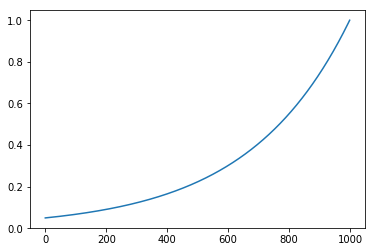

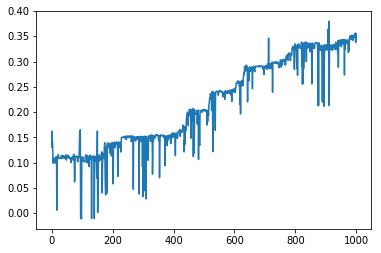

Before Cost = 43.91773223876953
After Cost = 26.963489532470703


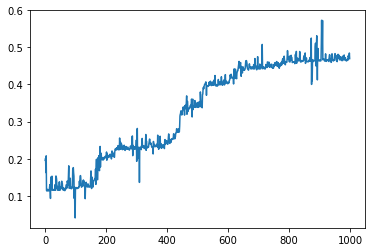

data7w.csv is loaded
Normal 7 wake_up 1


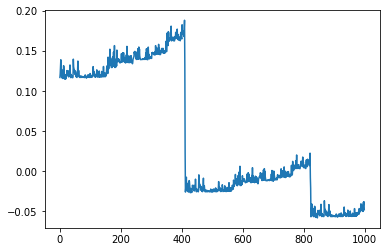

Before Cost = 8.500967025756836
After Cost = 7.753866672515869


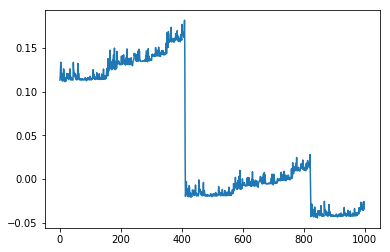

Patient 17 and dataset 1
data17_1.csv is loaded
Before Cost = 30.131738662719727
After Cost = 23.83951759338379
No such File
Patient 17 and dataset 2
data17_2.csv is loaded


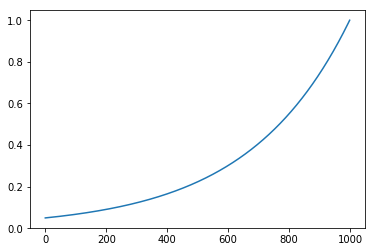

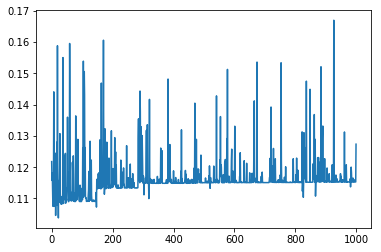

Before Cost = 106.08098602294922
After Cost = 98.001220703125


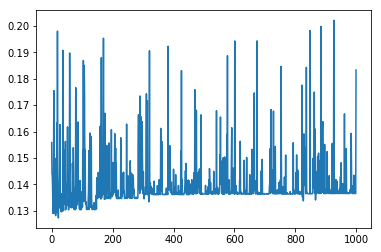

data8w.csv is loaded
Normal 8 wake_up 1


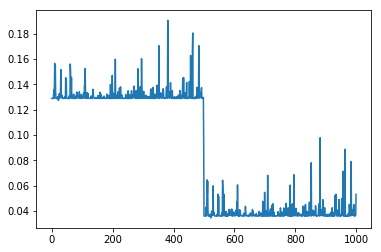

Before Cost = 9.430660247802734
After Cost = 9.715375900268555


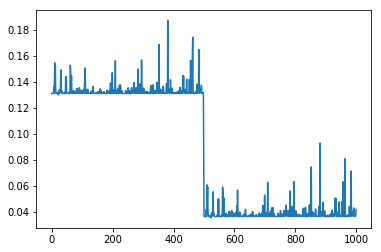

Patient 18 and dataset 1
data18_1.csv is loaded
Before Cost = 82.84388732910156
After Cost = 69.37727355957031
No such File
Patient 18 and dataset 3
data18_3.csv is loaded
Before Cost = 78.87222290039062
After Cost = 56.110877990722656
No such File
Patient 18 and dataset 4
data18_4.csv is loaded
Before Cost = 26.680112838745117
After Cost = 21.714839935302734
data9w.csv is loaded
Normal 9 wake_up 1
Before Cost = 17.614133834838867
After Cost = 6.874297142028809
Patient 1 and dataset 1
data1_1.csv is loaded
Before Cost = 94.01703643798828
After Cost = 89.48309326171875
No such File
Patient 1 and dataset 2
data1_2.csv is loaded
Before Cost = 89.23817443847656
After Cost = 82.51252746582031
data1w.csv is loaded
Normal 1 wake_up 1
Before Cost = 290.38232421875
After Cost = 7.63466739654541
Patient 1 and dataset 3
data1_3.csv is loaded
Before Cost = 91.56951904296875
After Cost = 88.63623046875
No such File
Patient 1 and dataset 4
data1_4.csv is loaded


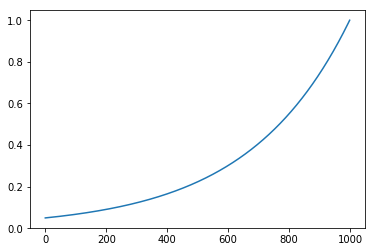

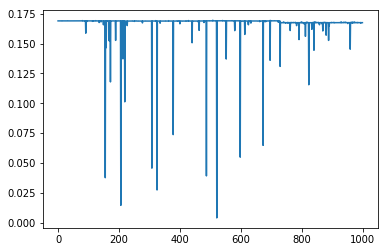

Before Cost = 88.79403686523438
After Cost = 82.51982116699219


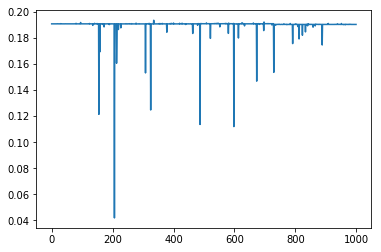

data1w.csv is loaded
Normal 1 wake_up 1


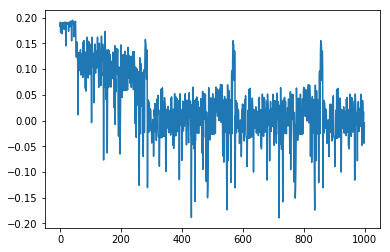

Before Cost = 5.891576766967773
After Cost = 5.449582576751709


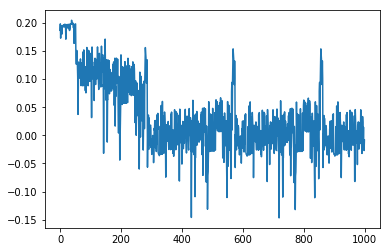

Patient 1 and dataset 5
data1_5.csv is loaded
Before Cost = 80.94574737548828
After Cost = 78.54269409179688
No such File
Patient 1 and dataset 6
data1_6.csv is loaded
Before Cost = 78.47825622558594
After Cost = 75.08685302734375
data1w.csv is loaded
Normal 1 wake_up 1
Before Cost = 7.654740333557129
After Cost = 6.215560436248779
Patient 1 and dataset 7
data1_7.csv is loaded
Before Cost = 79.18309020996094
After Cost = 74.42355346679688
No such File
Patient 2 and dataset 1
data2_1.csv is loaded
Before Cost = 73.28103637695312
After Cost = 71.30621337890625
No such File
Patient 2 and dataset 2
data2_2.csv is loaded
Before Cost = 71.21392822265625
After Cost = 69.71617126464844
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 19.42627716064453
After Cost = 15.22275447845459
Patient 2 and dataset 3
data2_3.csv is loaded
Before Cost = 70.18304443359375
After Cost = 69.88648986816406
No such File
Patient 2 and dataset 4
data2_4.csv is loaded
Before Cost = 69.61674499511719
After Cost

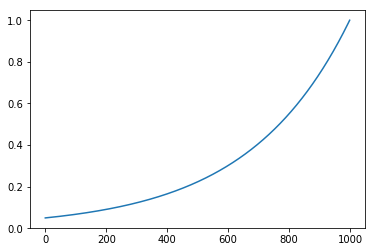

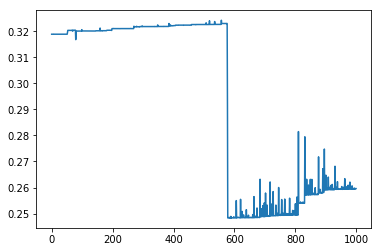

Before Cost = 81.27407836914062
After Cost = 73.91409301757812


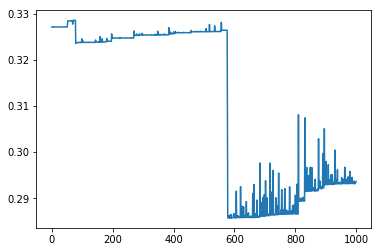

data3w.csv is loaded
Normal 3 wake_up 1


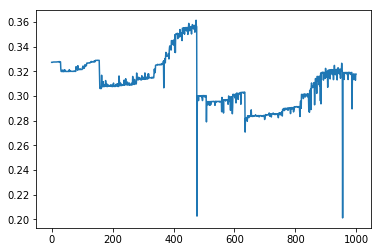

Before Cost = 97.04055786132812
After Cost = 35.78481674194336


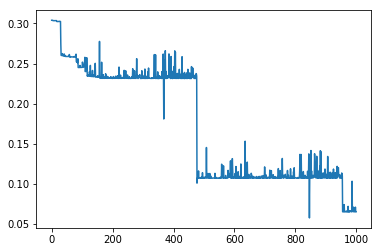

Patient 4 and dataset 1
data4_1.csv is loaded
Before Cost = 59.15653991699219
After Cost = 45.294700622558594
No such File
Patient 4 and dataset 2
data4_2.csv is loaded
Before Cost = 45.49333190917969
After Cost = 36.389652252197266
data4w.csv is loaded
Normal 4 wake_up 1
Before Cost = 5.5854692459106445
After Cost = 5.305160999298096
Patient 4 and dataset 3
data4_3.csv is loaded
Before Cost = 67.57868957519531
After Cost = 45.25226974487305
No such File
Patient 5 and dataset 2
data5_2.csv is loaded
Before Cost = 79.95123291015625
After Cost = 60.98055648803711
data5w.csv is loaded
Normal 5 wake_up 1
Before Cost = 34.850032806396484
After Cost = 24.915077209472656
Patient 5 and dataset 3
data5_3.csv is loaded
Before Cost = 86.11581420898438
After Cost = 75.78950500488281
No such File
Patient 5 and dataset 4
data5_4.csv is loaded
Before Cost = 52.74409484863281
After Cost = 40.96759033203125
data5w.csv is loaded
Normal 5 wake_up 1
Before Cost = 30.1494140625
After Cost = 18.386726379394

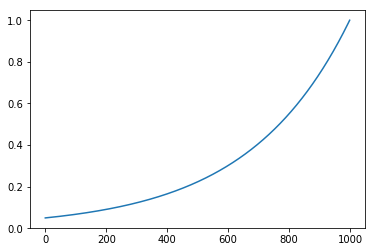

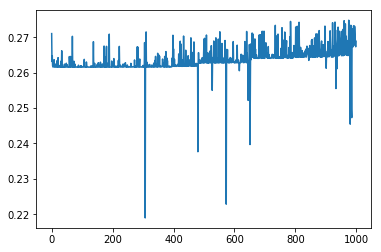

Before Cost = 68.07762145996094
After Cost = 66.07431030273438


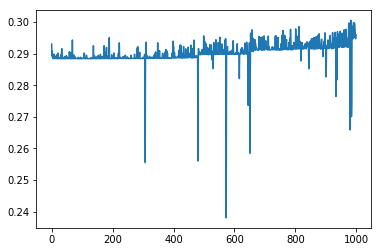

data7w.csv is loaded
Normal 7 wake_up 1


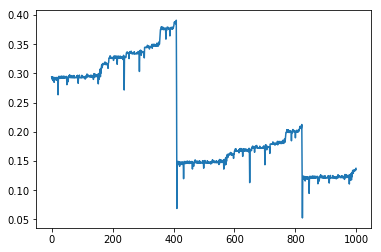

Before Cost = 57.3255729675293
After Cost = 32.43390655517578


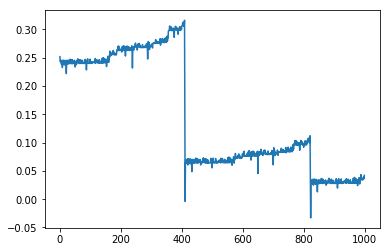

Patient 7 and dataset 3
data7_3.csv is loaded
Before Cost = 72.0291976928711
After Cost = 72.72045135498047
No such File
Patient 7 and dataset 4
data7_4.csv is loaded
Before Cost = 70.8857421875
After Cost = 67.01799011230469
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 37.507896423339844
After Cost = 26.131147384643555
Patient 7 and dataset 5
data7_5.csv is loaded
Before Cost = 73.39591217041016
After Cost = 72.09507751464844
No such File
Patient 7 and dataset 6
data7_6.csv is loaded
Before Cost = 71.201904296875
After Cost = 67.50865173339844
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 36.65327453613281
After Cost = 26.849628448486328
Patient 7 and dataset 7
data7_7.csv is loaded
Before Cost = 71.88302612304688
After Cost = 71.55319213867188
No such File
Patient 8 and dataset 1
data8_1.csv is loaded
Before Cost = 62.14307403564453
After Cost = 56.6378173828125
No such File
Patient 8 and dataset 2
data8_2.csv is loaded
Before Cost = 67.18510437011719
After Cost = 65

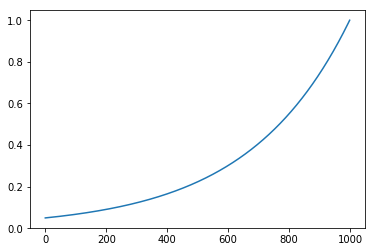

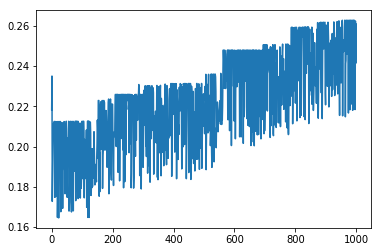

Before Cost = 67.9252700805664
After Cost = 37.33982849121094


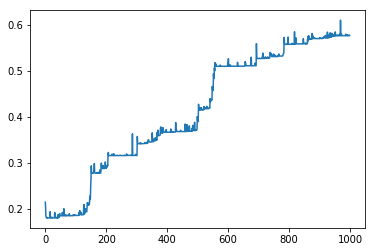

No such File
Patient 8 and dataset 9
data8_9.csv is loaded


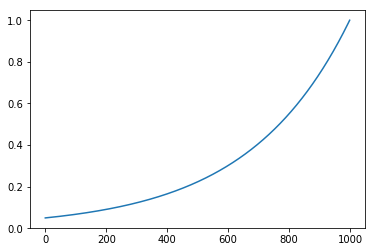

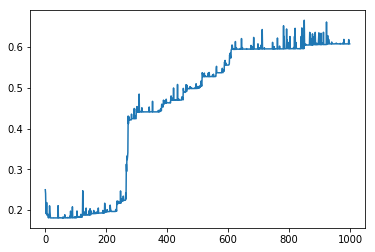

Before Cost = 46.840370178222656
After Cost = 26.431690216064453


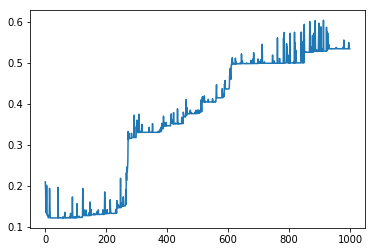

No such File
Patient 8 and dataset 10
data8_10.csv is loaded
Before Cost = 92.28718566894531
After Cost = 48.22187423706055
data8w.csv is loaded
Normal 8 wake_up 1
Before Cost = 166.16847229003906
After Cost = 20.850013732910156
Patient 8 and dataset 11
data8_11.csv is loaded
Before Cost = 95.14899444580078
After Cost = 73.26271057128906
No such File
Patient 8 and dataset 12
data8_12.csv is loaded
Before Cost = 71.35562896728516
After Cost = 65.15052795410156
data8w.csv is loaded
Normal 8 wake_up 1
Before Cost = 52.82649230957031
After Cost = 25.938173294067383
Patient 8 and dataset 13
data8_13.csv is loaded
Before Cost = 35.720542907714844
After Cost = 28.436481475830078
No such File
Patient 9 and dataset 3
data9_3.csv is loaded
Before Cost = 133.14544677734375
After Cost = 68.15552520751953
No such File
Patient 9 and dataset 4
data9_4.csv is loaded
Before Cost = 67.7354736328125
After Cost = 65.68679809570312
data9w.csv is loaded
Normal 9 wake_up 1
Before Cost = 118.67259216308594
Af

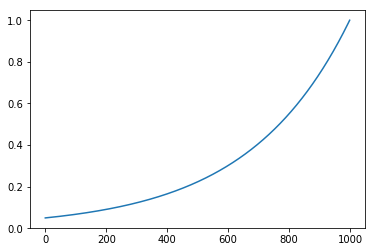

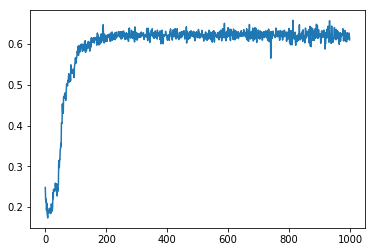

Before Cost = 136.17129516601562
After Cost = 65.5974349975586


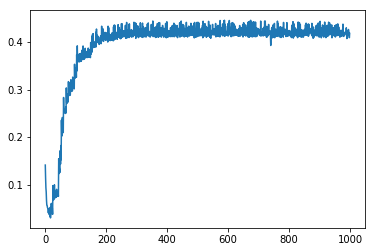

data5w.csv is loaded
Normal 5 wake_up 1


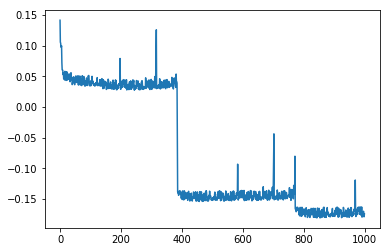

Before Cost = 15.551681518554688
After Cost = 9.85852336883545


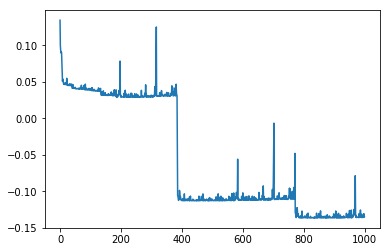

Patient 14 and dataset 3
data14_3.csv is loaded
Before Cost = 56.972877502441406
After Cost = 54.199562072753906
No such File
Patient 14 and dataset 4
data14_4.csv is loaded
Before Cost = 34.89165496826172
After Cost = 29.412765502929688
data5w.csv is loaded
Normal 5 wake_up 1
Before Cost = 5.379802227020264
After Cost = 5.056659698486328
Patient 14 and dataset 5
data14_5.csv is loaded
Before Cost = 46.82770919799805
After Cost = 38.272918701171875
No such File
Patient 14 and dataset 6
data14_6.csv is loaded
Before Cost = 34.34209442138672
After Cost = 29.19114112854004
data5w.csv is loaded
Normal 5 wake_up 1
Before Cost = 4.9246344566345215
After Cost = 4.996523380279541
Patient 15 and dataset 1
data15_1.csv is loaded


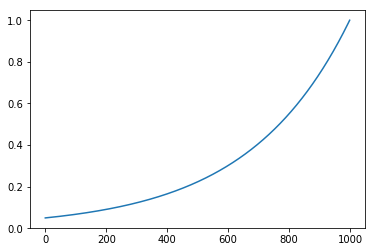

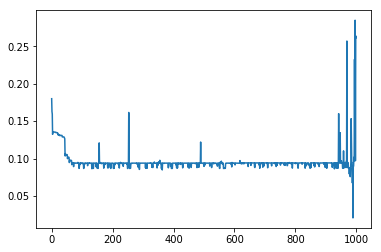

Before Cost = 114.95451354980469
After Cost = 77.40351867675781


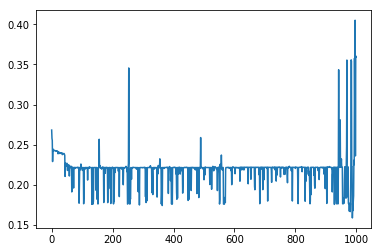

No such File
Patient 15 and dataset 2
data15_2.csv is loaded
Before Cost = 76.07559204101562
After Cost = 64.9464340209961
data6w.csv is loaded
Normal 6 wake_up 1
Before Cost = 98.78511810302734
After Cost = 30.696439743041992
Patient 15 and dataset 3
data15_3.csv is loaded
Before Cost = 80.49880981445312
After Cost = 77.84251403808594
No such File
Patient 15 and dataset 9
data15_9.csv is loaded
Before Cost = 63.420928955078125
After Cost = 51.183128356933594
No such File
Patient 15 and dataset 10
data15_10.csv is loaded
Before Cost = 55.58673858642578
After Cost = 53.77337646484375
data6w.csv is loaded
Normal 6 wake_up 1
Before Cost = 65.77181243896484
After Cost = 18.95849609375
Patient 15 and dataset 13
data15_13.csv is loaded
Before Cost = 99.80322265625
After Cost = 85.4223861694336
No such File
Patient 15 and dataset 14
data15_14.csv is loaded
Before Cost = 81.6290512084961
After Cost = 66.48846435546875
data6w.csv is loaded
Normal 6 wake_up 1
Before Cost = 64.4833984375
After Co

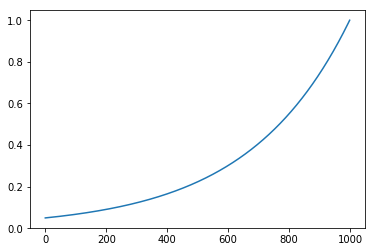

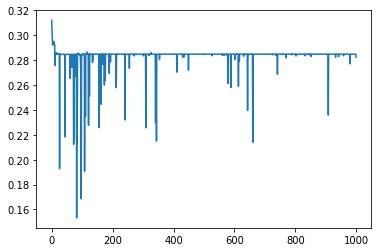

Before Cost = 66.85252380371094
After Cost = 65.67770385742188


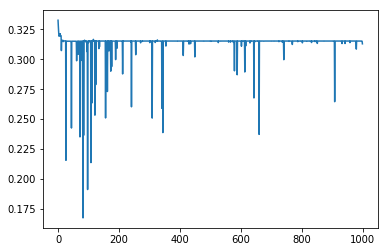

data6w.csv is loaded
Normal 6 wake_up 1


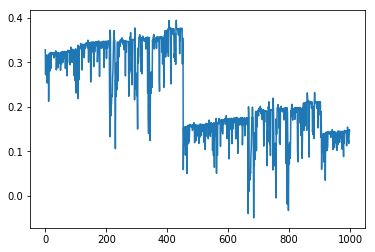

Before Cost = 62.53068923950195
After Cost = 24.520835876464844


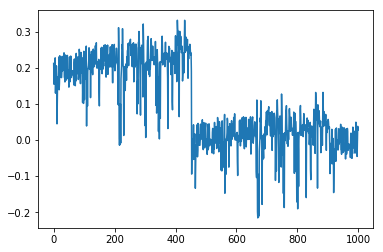

Patient 15 and dataset 23
data15_23.csv is loaded
Before Cost = 86.95064544677734
After Cost = 81.98788452148438
No such File
Patient 15 and dataset 24
data15_24.csv is loaded
Before Cost = 79.17909240722656
After Cost = 65.74515533447266
data6w.csv is loaded
Normal 6 wake_up 1
Before Cost = 49.724525451660156
After Cost = 27.2869815826416
Patient 15 and dataset 25
data15_25.csv is loaded
Before Cost = 80.63121032714844
After Cost = 77.62210845947266
No such File
Patient 15 and dataset 26
data15_26.csv is loaded
Before Cost = 72.98812866210938
After Cost = 67.53943634033203
data6w.csv is loaded
Normal 6 wake_up 1
Before Cost = 46.03242111206055
After Cost = 25.318164825439453
Patient 15 and dataset 27
data15_27.csv is loaded
Before Cost = 75.71288299560547
After Cost = 73.94442749023438
No such File
Patient 15 and dataset 29
data15_29.csv is loaded
Before Cost = 72.23220825195312
After Cost = 66.90234375
No such File
Patient 15 and dataset 30
data15_30.csv is loaded


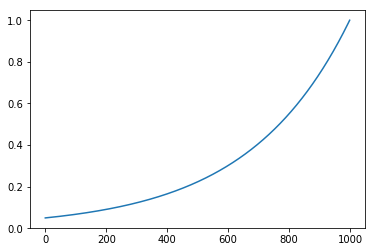

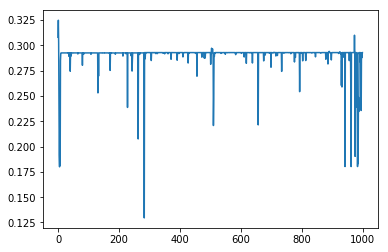

Before Cost = 67.85401916503906
After Cost = 67.07394409179688


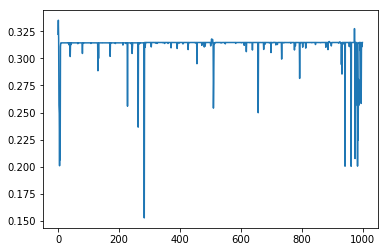

data6w.csv is loaded
Normal 6 wake_up 1


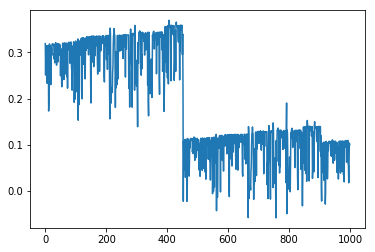

Before Cost = 48.768028259277344
After Cost = 21.670269012451172


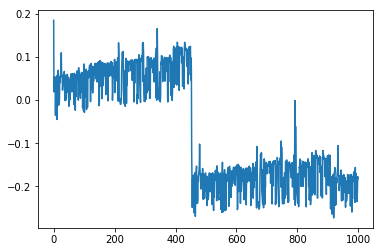

Patient 16 and dataset 1
data16_1.csv is loaded
Before Cost = 133.91485595703125
After Cost = 62.300350189208984
No such File
Patient 16 and dataset 2
data16_2.csv is loaded
Before Cost = 64.9366455078125
After Cost = 51.09846878051758
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 47.41947555541992
After Cost = 24.19878578186035
Patient 16 and dataset 3
data16_3.csv is loaded
Before Cost = 34.60852813720703
After Cost = 24.13101577758789
No such File
Patient 16 and dataset 4
data16_4.csv is loaded
Before Cost = 43.88453674316406
After Cost = 20.496307373046875
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 17.114587783813477
After Cost = 16.699392318725586
Patient 16 and dataset 5
data16_5.csv is loaded
Before Cost = 88.33171081542969
After Cost = 46.058509826660156
No such File
Patient 16 and dataset 6
data16_6.csv is loaded
Before Cost = 45.46516418457031
After Cost = 43.720184326171875
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 12.499323844909668
After Cost

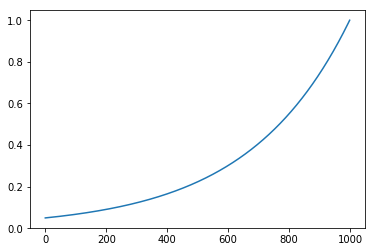

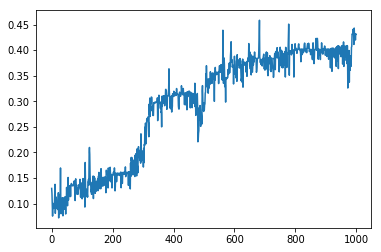

Before Cost = 34.96625518798828
After Cost = 33.080997467041016


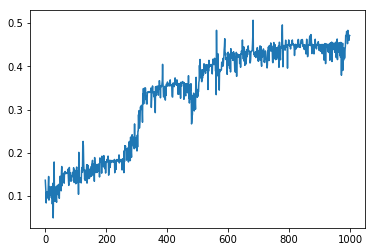

No such File
Patient 16 and dataset 8
data16_8.csv is loaded
Before Cost = 27.178171157836914
After Cost = 22.41742706298828
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 11.73370361328125
After Cost = 10.616333961486816
Patient 17 and dataset 1
data17_1.csv is loaded
Before Cost = 30.48299789428711
After Cost = 23.985979080200195
No such File
Patient 17 and dataset 2
data17_2.csv is loaded


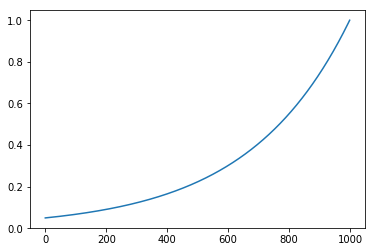

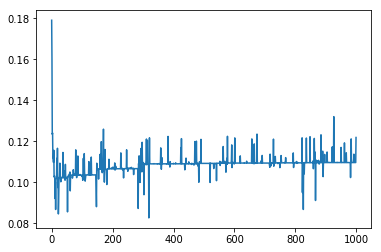

Before Cost = 108.83465576171875
After Cost = 87.11030578613281


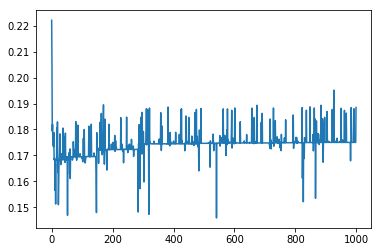

data8w.csv is loaded
Normal 8 wake_up 1


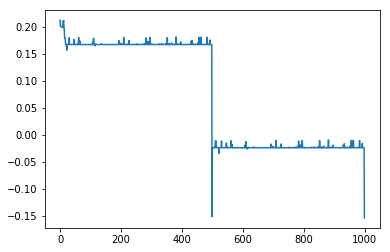

Before Cost = 14.660924911499023
After Cost = 15.677225112915039


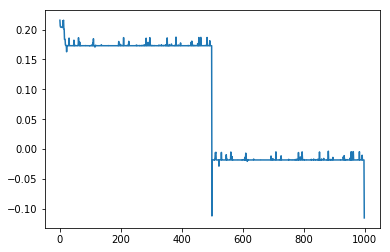

Patient 18 and dataset 1
data18_1.csv is loaded
Before Cost = 69.86905670166016
After Cost = 59.29023742675781
No such File
Patient 18 and dataset 3
data18_3.csv is loaded
Before Cost = 68.24181365966797
After Cost = 56.90357971191406
No such File
Patient 18 and dataset 4
data18_4.csv is loaded
Before Cost = 25.553491592407227
After Cost = 22.45550537109375
data9w.csv is loaded
Normal 9 wake_up 1
Before Cost = 182.21737670898438
After Cost = 7.271854877471924
Patient 1 and dataset 1
data1_1.csv is loaded
Before Cost = 95.00886535644531
After Cost = 84.38915252685547
No such File
Patient 1 and dataset 2
data1_2.csv is loaded
Before Cost = 83.64021301269531
After Cost = 70.89935302734375
data1w.csv is loaded
Normal 1 wake_up 1
Before Cost = 33.638187408447266
After Cost = 10.395600318908691
Patient 1 and dataset 3
data1_3.csv is loaded
Before Cost = 77.28977966308594
After Cost = 70.48490905761719
No such File
Patient 1 and dataset 4
data1_4.csv is loaded
Before Cost = 70.48130798339844


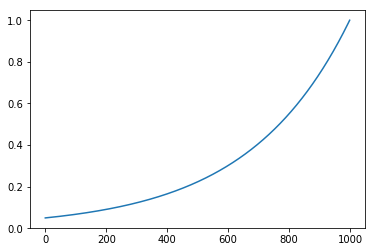

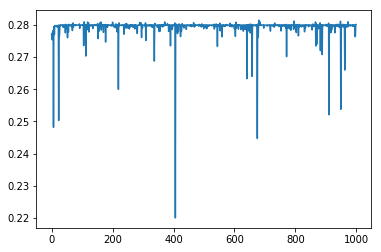

Before Cost = 67.56922912597656
After Cost = 66.43247985839844


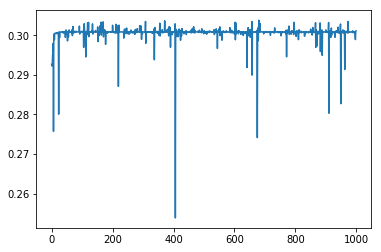

No such File
Patient 2 and dataset 2
data2_2.csv is loaded
Before Cost = 66.21003723144531
After Cost = 65.91780090332031
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 29.451032638549805
After Cost = 15.303254127502441
Patient 2 and dataset 3
data2_3.csv is loaded


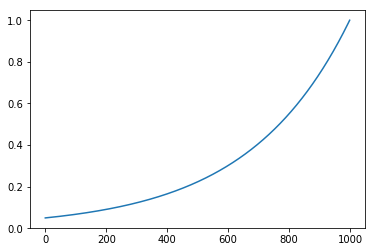

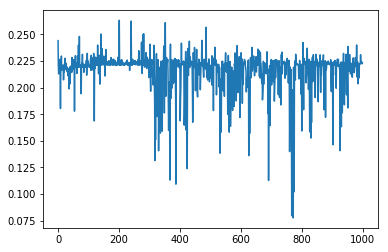

Before Cost = 77.5514144897461
After Cost = 65.33403015136719


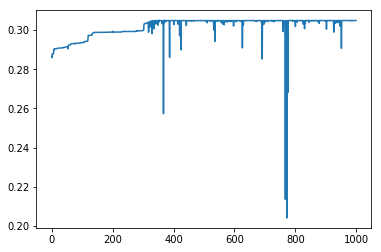

No such File
Patient 2 and dataset 4
data2_4.csv is loaded
Before Cost = 65.91036987304688
After Cost = 65.71485900878906
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 27.220829010009766
After Cost = 11.956700325012207
Patient 2 and dataset 5
data2_5.csv is loaded
Before Cost = 282.55120849609375
After Cost = 97.97200012207031
No such File
Patient 2 and dataset 6
data2_6.csv is loaded
Before Cost = 68.17508697509766
After Cost = 68.6221923828125
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 78.2003173828125
After Cost = 33.44057846069336
Patient 2 and dataset 7
data2_7.csv is loaded
Before Cost = 70.85892486572266
After Cost = 73.29844665527344
No such File
Patient 3 and dataset 1
data3_1.csv is loaded


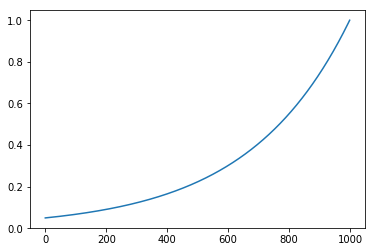

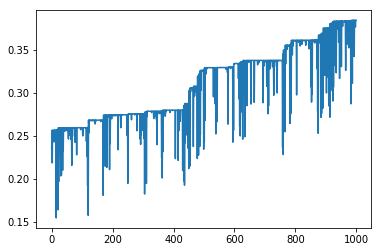

Before Cost = 49.3321533203125
After Cost = 43.15019989013672


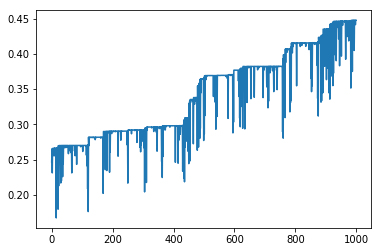

No such File
Patient 3 and dataset 5
data3_5.csv is loaded


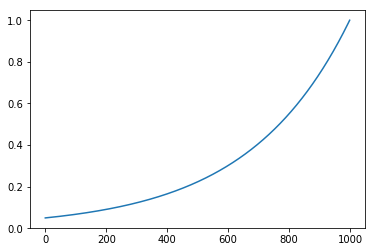

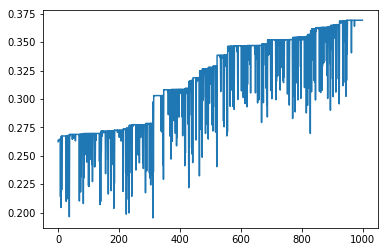

Before Cost = 51.3560905456543
After Cost = 41.90640640258789


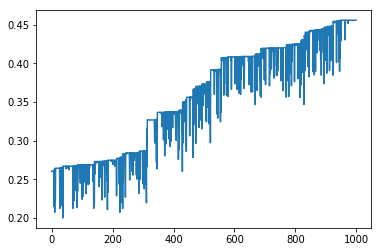

No such File
Patient 3 and dataset 6
data3_6.csv is loaded
Before Cost = 69.18998718261719
After Cost = 67.8363037109375
data3w.csv is loaded
Normal 3 wake_up 1
Before Cost = 40.166481018066406
After Cost = 25.60499382019043
Patient 4 and dataset 1
data4_1.csv is loaded
Before Cost = 30.12651824951172
After Cost = 27.255342483520508
No such File
Patient 4 and dataset 2
data4_2.csv is loaded
Before Cost = 58.50757598876953
After Cost = 32.25318908691406
data4w.csv is loaded
Normal 4 wake_up 1
Before Cost = 6.927803993225098
After Cost = 4.1968488693237305
Patient 4 and dataset 3
data4_3.csv is loaded


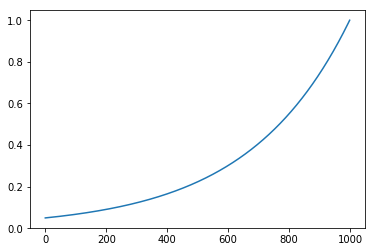

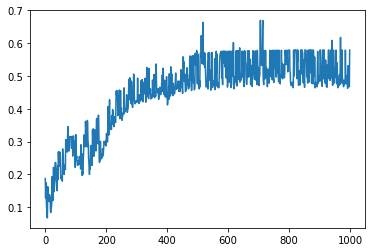

Before Cost = 60.42257308959961
After Cost = 35.732452392578125


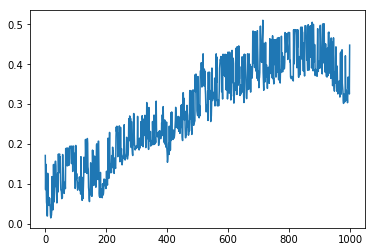

No such File
Patient 5 and dataset 2
data5_2.csv is loaded
Before Cost = 74.103515625
After Cost = 49.97028350830078
data5w.csv is loaded
Normal 5 wake_up 1
Before Cost = 15.682523727416992
After Cost = 13.834762573242188
Patient 5 and dataset 3
data5_3.csv is loaded
Before Cost = 82.99259185791016
After Cost = 75.99798583984375
No such File
Patient 5 and dataset 4
data5_4.csv is loaded
Before Cost = 41.98114013671875
After Cost = 33.089847564697266
data5w.csv is loaded
Normal 5 wake_up 1
Before Cost = 23.096437454223633
After Cost = 16.143983840942383
Patient 6 and dataset 1
data6_1.csv is loaded


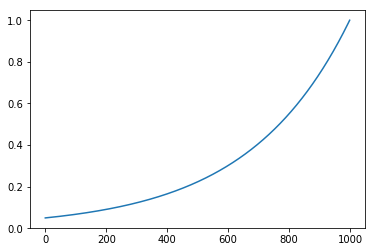

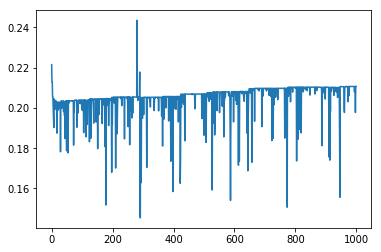

Before Cost = 77.53544616699219
After Cost = 72.92282104492188


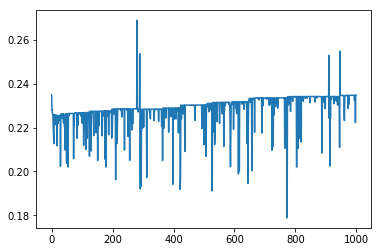

No such File
Patient 7 and dataset 1
data7_1.csv is loaded
Before Cost = 72.16578674316406
After Cost = 65.80423736572266
No such File
Patient 7 and dataset 2
data7_2.csv is loaded


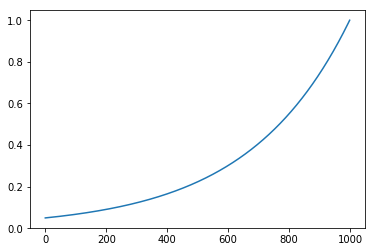

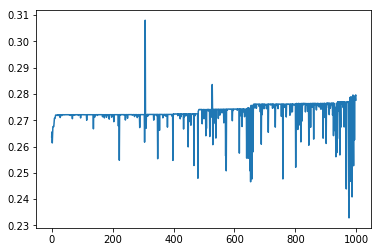

Before Cost = 67.86726379394531
After Cost = 65.83235168457031


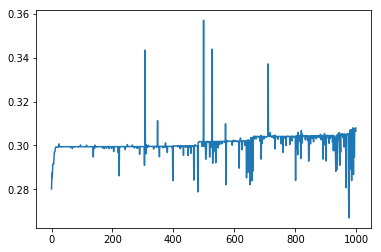

data7w.csv is loaded
Normal 7 wake_up 1


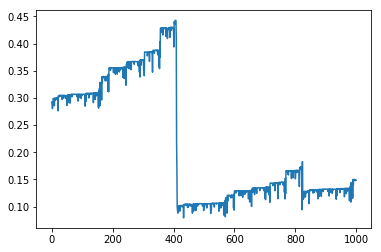

Before Cost = 59.85176467895508
After Cost = 31.44091796875


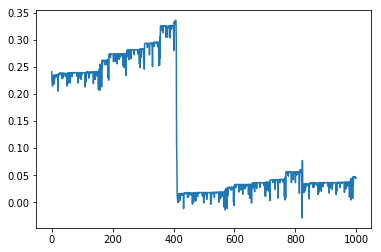

Patient 7 and dataset 3
data7_3.csv is loaded
Before Cost = 72.44657135009766
After Cost = 72.9395751953125
No such File
Patient 7 and dataset 4
data7_4.csv is loaded
Before Cost = 69.90433502197266
After Cost = 65.37439727783203
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 39.628021240234375
After Cost = 27.36492919921875
Patient 7 and dataset 5
data7_5.csv is loaded
Before Cost = 71.5365982055664
After Cost = 70.72402954101562
No such File
Patient 7 and dataset 6
data7_6.csv is loaded
Before Cost = 70.88400268554688
After Cost = 66.39756774902344
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 38.63389205932617
After Cost = 27.331836700439453
Patient 7 and dataset 7
data7_7.csv is loaded
Before Cost = 72.34056091308594
After Cost = 71.69541931152344
No such File
Patient 8 and dataset 1
data8_1.csv is loaded
Before Cost = 56.802032470703125
After Cost = 46.91371154785156
No such File
Patient 8 and dataset 2
data8_2.csv is loaded
Before Cost = 66.21490478515625
After Cos

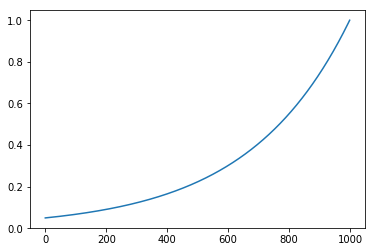

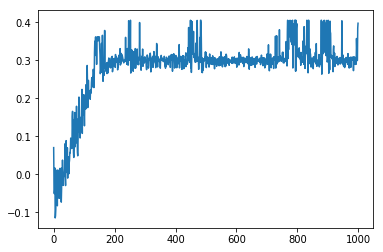

Before Cost = 58.14875030517578
After Cost = 54.20159912109375


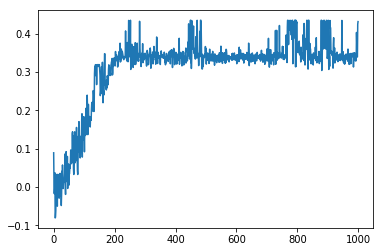

data9w.csv is loaded
Normal 9 wake_up 1


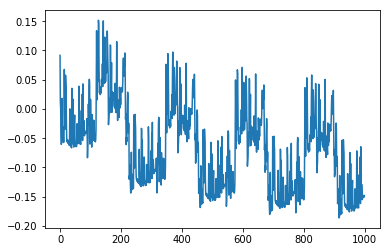

Before Cost = 9.332155227661133
After Cost = 3.843555450439453


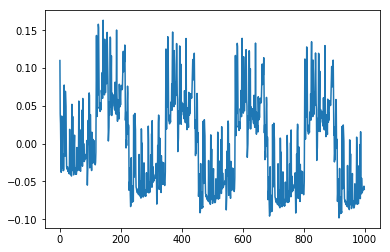

Patient 9 and dataset 13
data9_13.csv is loaded
Before Cost = 53.56208419799805
After Cost = 47.90092468261719
No such File
Patient 9 and dataset 14
data9_14.csv is loaded
Before Cost = 53.315738677978516
After Cost = 38.696319580078125
data9w.csv is loaded
Normal 9 wake_up 1
Before Cost = 11.499223709106445
After Cost = 2.8350939750671387
Patient 9 and dataset 15
data9_15.csv is loaded
Before Cost = 69.15251159667969
After Cost = 54.32087707519531
No such File
Patient 9 and dataset 16
data9_16.csv is loaded
Before Cost = 65.69990539550781
After Cost = 23.814102172851562
data9w.csv is loaded
Normal 9 wake_up 1
Before Cost = 8.709884643554688
After Cost = 3.3595244884490967
Patient 11 and dataset 1
data11_1.csv is loaded
Before Cost = 34.39607238769531
After Cost = 28.628482818603516
No such File
Patient 11 and dataset 2
data11_2.csv is loaded
Before Cost = 42.078487396240234
After Cost = 38.61918258666992
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 16.075145721435547
After Co

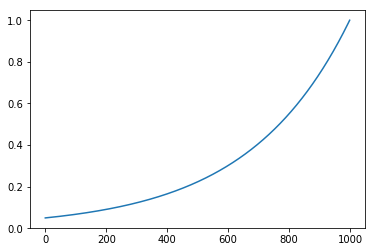

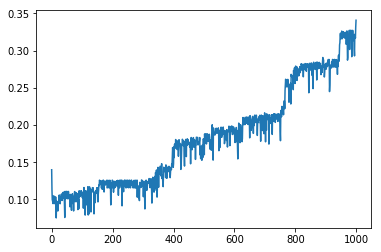

Before Cost = 55.32624816894531
After Cost = 20.780746459960938


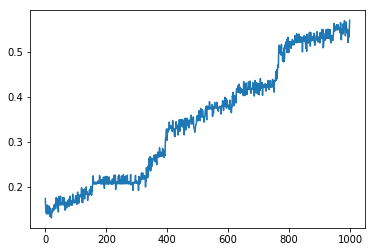

No such File
Patient 11 and dataset 6
data11_6.csv is loaded
Before Cost = 34.5345573425293
After Cost = 31.706819534301758
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 46.84843444824219
After Cost = 10.390560150146484
Patient 11 and dataset 7
data11_7.csv is loaded
Before Cost = 49.30326843261719
After Cost = 39.55324935913086
No such File
Patient 11 and dataset 8
data11_8.csv is loaded
Before Cost = 94.66191864013672
After Cost = 31.396221160888672
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 23.37291717529297
After Cost = 12.491455078125
Patient 12 and dataset 1
data12_1.csv is loaded
Before Cost = 71.92906951904297
After Cost = 32.96709060668945
No such File
Patient 13 and dataset 1
data13_1.csv is loaded
Before Cost = 31.85860824584961
After Cost = 24.984901428222656
No such File
Patient 13 and dataset 2
data13_2.csv is loaded
Before Cost = 53.65830993652344
After Cost = 29.052629470825195
data4w.csv is loaded
Normal 4 wake_up 1
Before Cost = 6.061723232269287
Af

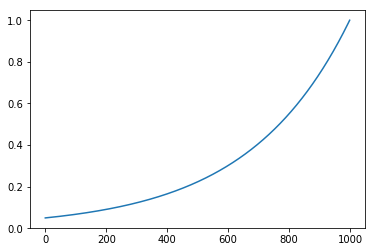

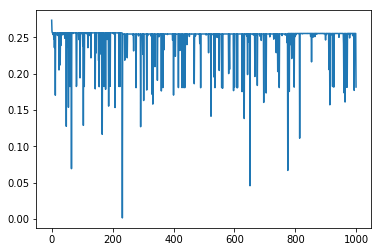

Before Cost = 71.25331115722656
After Cost = 70.38984680175781


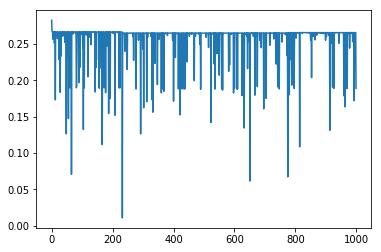

No such File
Patient 15 and dataset 29
data15_29.csv is loaded
Before Cost = 68.87022399902344
After Cost = 65.06336212158203
No such File
Patient 15 and dataset 30
data15_30.csv is loaded


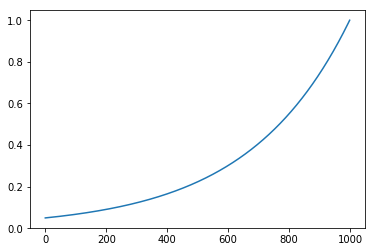

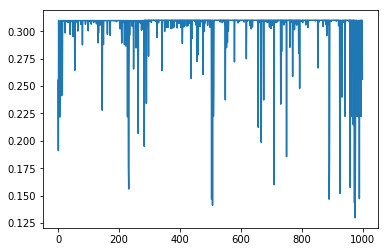

Before Cost = 68.8741455078125
After Cost = 68.4759521484375


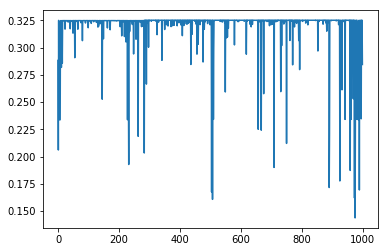

data6w.csv is loaded
Normal 6 wake_up 1


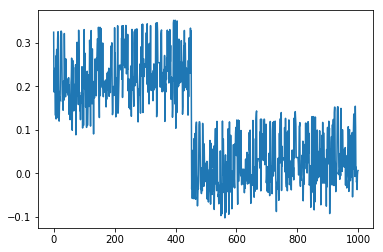

Before Cost = 26.576356887817383
After Cost = 13.59541130065918


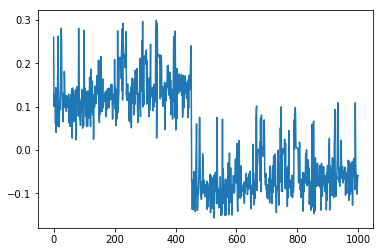

Patient 16 and dataset 1
data16_1.csv is loaded
Before Cost = 102.62065124511719
After Cost = 74.2509765625
No such File
Patient 16 and dataset 2
data16_2.csv is loaded
Before Cost = 58.46836471557617
After Cost = 30.26955795288086
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 42.82814025878906
After Cost = 10.984827041625977
Patient 16 and dataset 3
data16_3.csv is loaded
Before Cost = 22.642091751098633
After Cost = 20.994396209716797
No such File
Patient 16 and dataset 4
data16_4.csv is loaded
Before Cost = 42.696998596191406
After Cost = 20.930662155151367
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 12.342594146728516
After Cost = 9.80335807800293
Patient 16 and dataset 5
data16_5.csv is loaded


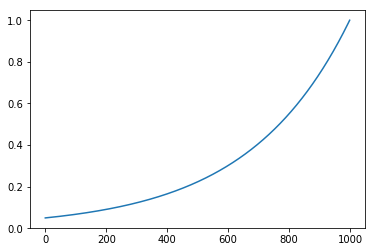

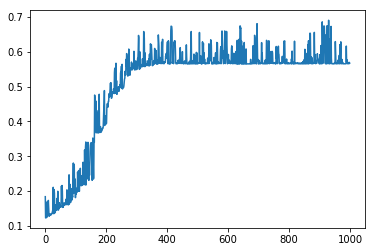

Before Cost = 85.61822509765625
After Cost = 41.66265106201172


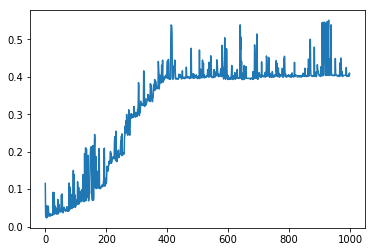

No such File
Patient 16 and dataset 6
data16_6.csv is loaded
Before Cost = 59.56824493408203
After Cost = 42.06301498413086
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 9.177149772644043
After Cost = 6.70394229888916
Patient 16 and dataset 7
data16_7.csv is loaded
Before Cost = 34.62279510498047
After Cost = 31.320831298828125
No such File
Patient 16 and dataset 8
data16_8.csv is loaded
Before Cost = 27.530601501464844
After Cost = 18.60748291015625
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 7.01157283782959
After Cost = 6.086565971374512
Patient 17 and dataset 1
data17_1.csv is loaded
Before Cost = 28.699748992919922
After Cost = 19.64190673828125
No such File
Patient 17 and dataset 2
data17_2.csv is loaded
Before Cost = 127.93817138671875
After Cost = 81.34320068359375
data8w.csv is loaded
Normal 8 wake_up 1
Before Cost = 18.909791946411133
After Cost = 17.666229248046875
Patient 18 and dataset 1
data18_1.csv is loaded
Before Cost = 69.74313354492188
After Cost = 

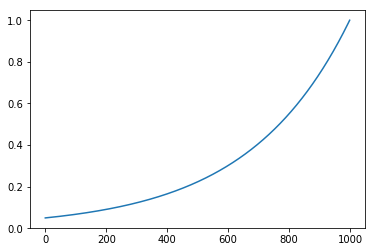

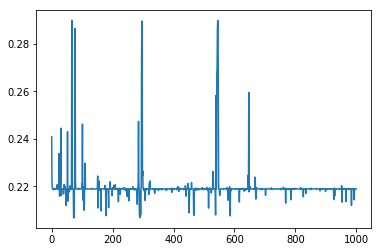

Before Cost = 75.87548828125
After Cost = 66.6866226196289


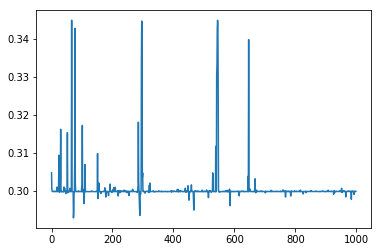

data1w.csv is loaded
Normal 1 wake_up 1


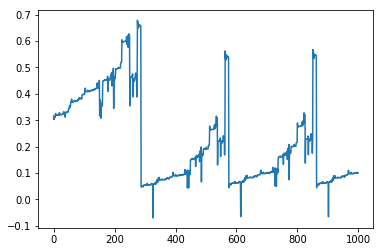

Before Cost = 76.74208068847656
After Cost = 21.252166748046875


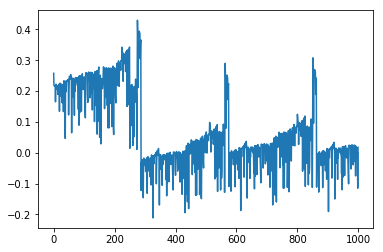

Patient 1 and dataset 3
data1_3.csv is loaded
Before Cost = 75.93232727050781
After Cost = 73.21755981445312
No such File
Patient 1 and dataset 4
data1_4.csv is loaded
Before Cost = 72.61231231689453
After Cost = 66.6851577758789
data1w.csv is loaded
Normal 1 wake_up 1
Before Cost = 30.772722244262695
After Cost = 10.363300323486328
Patient 1 and dataset 5
data1_5.csv is loaded
Before Cost = 126.04267883300781
After Cost = 66.98966979980469
No such File
Patient 1 and dataset 6
data1_6.csv is loaded
Before Cost = 66.7254638671875
After Cost = 66.20879364013672
data1w.csv is loaded
Normal 1 wake_up 1
Before Cost = 31.144079208374023
After Cost = 12.055440902709961
Patient 1 and dataset 7
data1_7.csv is loaded


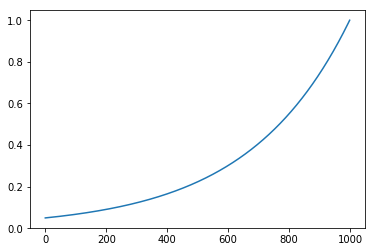

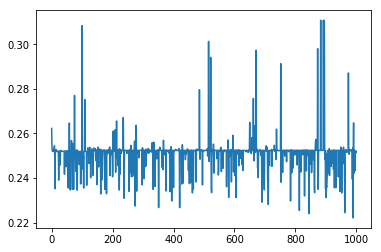

Before Cost = 70.3814697265625
After Cost = 69.21275329589844


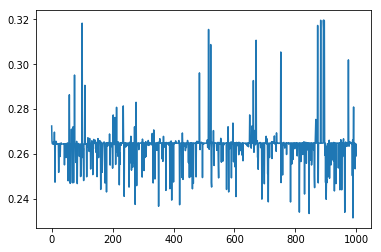

No such File
Patient 2 and dataset 1
data2_1.csv is loaded
Before Cost = 68.88927459716797
After Cost = 66.36557006835938
No such File
Patient 2 and dataset 2
data2_2.csv is loaded
Before Cost = 66.3243408203125
After Cost = 66.13473510742188
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 32.62560272216797
After Cost = 9.23562240600586
Patient 2 and dataset 3
data2_3.csv is loaded
Before Cost = 70.32259368896484
After Cost = 68.15122985839844
No such File
Patient 2 and dataset 4
data2_4.csv is loaded
Before Cost = 79.66704559326172
After Cost = 67.23786163330078
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 26.459087371826172
After Cost = 8.691247940063477
Patient 2 and dataset 5
data2_5.csv is loaded
Before Cost = 165.42665100097656
After Cost = 80.24757385253906
No such File
Patient 2 and dataset 6
data2_6.csv is loaded
Before Cost = 81.29901123046875
After Cost = 68.2991943359375
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 86.7096176147461
After Cost = 8.322

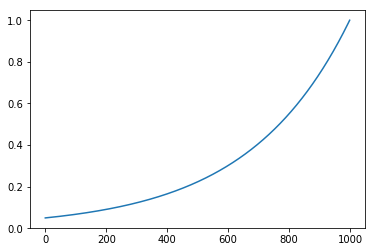

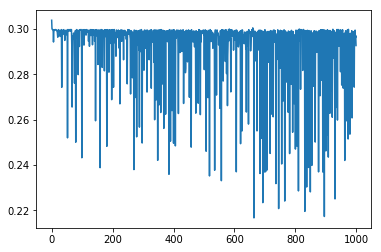

Before Cost = 68.05162048339844
After Cost = 67.6349868774414


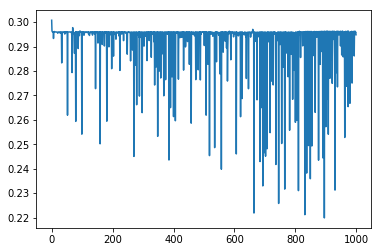

data3w.csv is loaded
Normal 3 wake_up 1


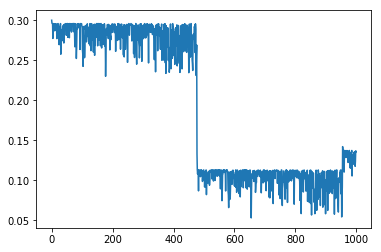

Before Cost = 43.9558219909668
After Cost = 22.09422492980957


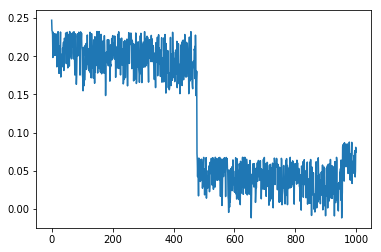

Patient 4 and dataset 1
data4_1.csv is loaded
Before Cost = 30.308982849121094
After Cost = 23.84359359741211
No such File
Patient 4 and dataset 2
data4_2.csv is loaded
Before Cost = 46.09307098388672
After Cost = 25.612367630004883
data4w.csv is loaded
Normal 4 wake_up 1
Before Cost = 4.2919206619262695
After Cost = 1.7675116062164307
Patient 4 and dataset 3
data4_3.csv is loaded
Before Cost = 56.55768585205078
After Cost = 31.305519104003906
No such File
Patient 5 and dataset 2
data5_2.csv is loaded
Before Cost = 113.45003509521484
After Cost = 57.72670364379883
data5w.csv is loaded
Normal 5 wake_up 1
Before Cost = 13.952254295349121
After Cost = 10.445181846618652
Patient 5 and dataset 3
data5_3.csv is loaded


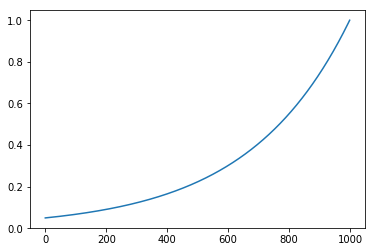

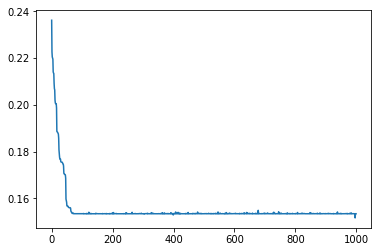

Before Cost = 93.24739837646484
After Cost = 77.21617126464844


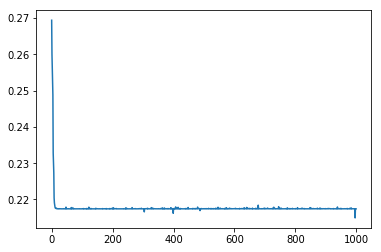

No such File
Patient 5 and dataset 4
data5_4.csv is loaded
Before Cost = 45.33598327636719
After Cost = 35.09204864501953
data5w.csv is loaded
Normal 5 wake_up 1
Before Cost = 35.17193603515625
After Cost = 11.815378189086914
Patient 6 and dataset 1
data6_1.csv is loaded
Before Cost = 86.09060668945312
After Cost = 75.4400634765625
No such File
Patient 7 and dataset 1
data7_1.csv is loaded
Before Cost = 75.922119140625
After Cost = 65.40425872802734
No such File
Patient 7 and dataset 2
data7_2.csv is loaded
Before Cost = 65.8149185180664
After Cost = 64.9488525390625
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 78.02832794189453
After Cost = 24.832443237304688
Patient 7 and dataset 3
data7_3.csv is loaded


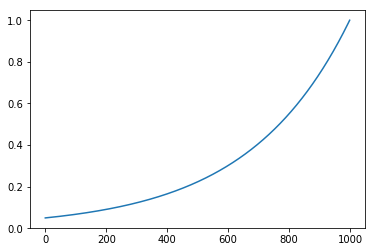

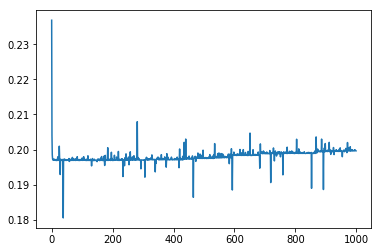

Before Cost = 79.80451965332031
After Cost = 77.33372497558594


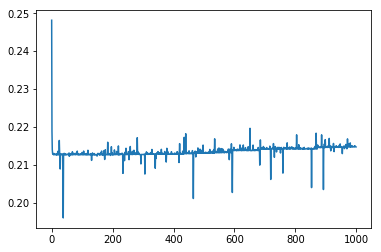

No such File
Patient 7 and dataset 4
data7_4.csv is loaded
Before Cost = 74.14332580566406
After Cost = 65.19432067871094
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 48.257877349853516
After Cost = 23.94908905029297
Patient 7 and dataset 5
data7_5.csv is loaded
Before Cost = 75.68782043457031
After Cost = 73.04476165771484
No such File
Patient 7 and dataset 6
data7_6.csv is loaded
Before Cost = 73.45352172851562
After Cost = 66.042724609375
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 45.801212310791016
After Cost = 24.693721771240234
Patient 7 and dataset 7
data7_7.csv is loaded
Before Cost = 75.88743591308594
After Cost = 73.67618560791016
No such File
Patient 8 and dataset 1
data8_1.csv is loaded
Before Cost = 59.391029357910156
After Cost = 50.802490234375
No such File
Patient 8 and dataset 2
data8_2.csv is loaded
Before Cost = 65.29418182373047
After Cost = 62.54977798461914
data8w.csv is loaded
Normal 8 wake_up 1
Before Cost = 47.94805145263672
After Cost = 23.

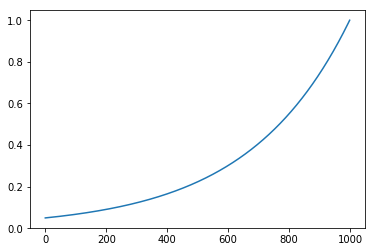

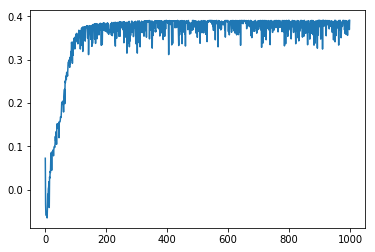

Before Cost = 61.337738037109375
After Cost = 58.16962814331055


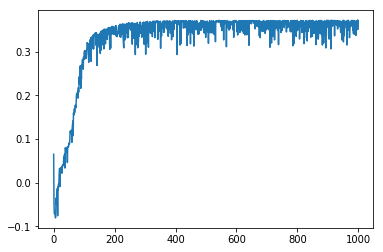

No such File
Patient 9 and dataset 16
data9_16.csv is loaded
Before Cost = 43.36697006225586
After Cost = 25.49774742126465
data9w.csv is loaded
Normal 9 wake_up 1
Before Cost = 8.014337539672852
After Cost = 3.04587721824646
Patient 11 and dataset 1
data11_1.csv is loaded
Before Cost = 32.9085693359375
After Cost = 28.990123748779297
No such File
Patient 11 and dataset 2
data11_2.csv is loaded
Before Cost = 35.93825912475586
After Cost = 31.96363067626953
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 15.515430450439453
After Cost = 8.766803741455078
Patient 11 and dataset 3
data11_3.csv is loaded
Before Cost = 38.26171875
After Cost = 27.55600357055664
No such File
Patient 11 and dataset 4
data11_4.csv is loaded
Before Cost = 31.653573989868164
After Cost = 21.01386260986328
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 9.463606834411621
After Cost = 6.3743414878845215
Patient 11 and dataset 5
data11_5.csv is loaded
Before Cost = 55.4644660949707
After Cost = 18.012363

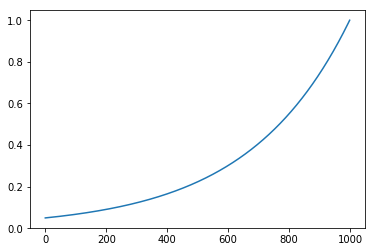

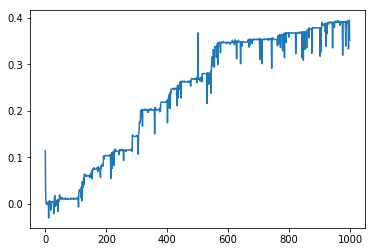

Before Cost = 34.365379333496094
After Cost = 26.816612243652344


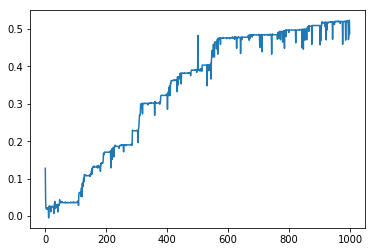

data4w.csv is loaded
Normal 4 wake_up 1


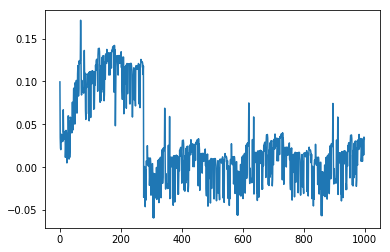

Before Cost = 3.33359432220459
After Cost = 2.3788506984710693


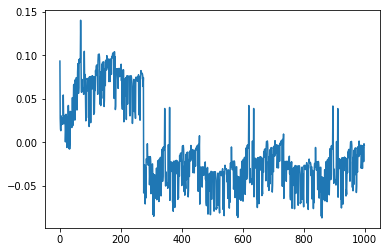

Patient 13 and dataset 3
data13_3.csv is loaded
Before Cost = 131.93405151367188
After Cost = 66.4502944946289
No such File
Patient 14 and dataset 1
data14_1.csv is loaded
Before Cost = 36.355220794677734
After Cost = 30.980636596679688
No such File
Patient 14 and dataset 2
data14_2.csv is loaded
Before Cost = 201.19546508789062
After Cost = 62.964195251464844
data5w.csv is loaded
Normal 5 wake_up 1
Before Cost = 3.216261863708496
After Cost = 3.35860538482666
Patient 14 and dataset 3
data14_3.csv is loaded
Before Cost = 61.45890808105469
After Cost = 59.09352493286133
No such File
Patient 14 and dataset 4
data14_4.csv is loaded
Before Cost = 44.38694763183594
After Cost = 34.55896759033203
data5w.csv is loaded
Normal 5 wake_up 1
Before Cost = 3.033449649810791
After Cost = 3.1519775390625
Patient 14 and dataset 5
data14_5.csv is loaded
Before Cost = 49.99798583984375
After Cost = 40.67780685424805
No such File
Patient 14 and dataset 6
data14_6.csv is loaded
Before Cost = 39.2646026611

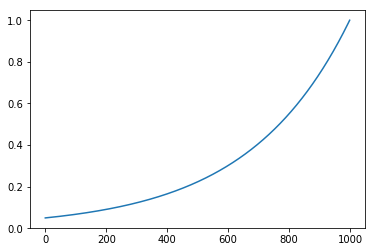

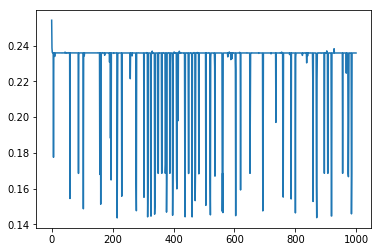

Before Cost = 74.03726196289062
After Cost = 72.97813415527344


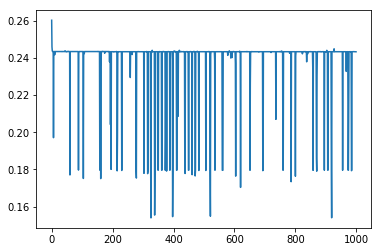

No such File
Patient 15 and dataset 24
data15_24.csv is loaded
Before Cost = 73.25480651855469
After Cost = 67.07550811767578
data6w.csv is loaded
Normal 6 wake_up 1
Before Cost = 29.474502563476562
After Cost = 13.814275741577148
Patient 15 and dataset 25
data15_25.csv is loaded
Before Cost = 71.31452941894531
After Cost = 57.82565689086914
No such File
Patient 15 and dataset 26
data15_26.csv is loaded
Before Cost = 69.97901916503906
After Cost = 67.29803466796875
data6w.csv is loaded
Normal 6 wake_up 1
Before Cost = 23.736671447753906
After Cost = 8.937734603881836
Patient 15 and dataset 27
data15_27.csv is loaded
Before Cost = 69.43746948242188
After Cost = 66.10942077636719
No such File
Patient 15 and dataset 29
data15_29.csv is loaded
Before Cost = 69.05049896240234
After Cost = 64.9793701171875
No such File
Patient 15 and dataset 30
data15_30.csv is loaded
Before Cost = 68.55467987060547
After Cost = 68.2333755493164
data6w.csv is loaded
Normal 6 wake_up 1
Before Cost = 30.778215

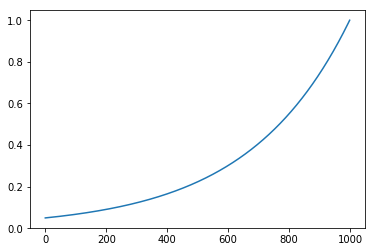

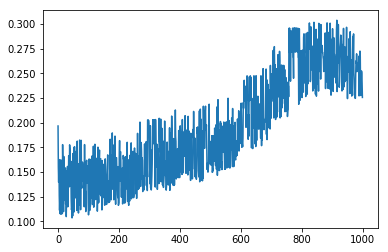

Before Cost = 61.36516189575195
After Cost = 24.80459213256836


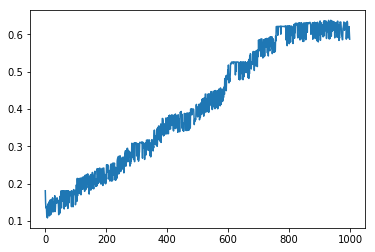

No such File
Patient 4 and dataset 2
data4_2.csv is loaded
Before Cost = 38.836158752441406
After Cost = 23.807144165039062
data4w.csv is loaded
Normal 4 wake_up 1
Before Cost = 8.559850692749023
After Cost = 2.713054656982422
Patient 4 and dataset 3
data4_3.csv is loaded
Before Cost = 110.52972412109375
After Cost = 36.517723083496094
No such File
Patient 5 and dataset 2
data5_2.csv is loaded
Before Cost = 102.67507934570312
After Cost = 44.30192565917969
data5w.csv is loaded
Normal 5 wake_up 1
Before Cost = 9.994462013244629
After Cost = 9.182040214538574
Patient 5 and dataset 3
data5_3.csv is loaded
Before Cost = 92.67533874511719
After Cost = 75.64059448242188
No such File
Patient 5 and dataset 4
data5_4.csv is loaded
Before Cost = 31.738292694091797
After Cost = 28.639076232910156
data5w.csv is loaded
Normal 5 wake_up 1
Before Cost = 24.200319290161133
After Cost = 9.336908340454102
Patient 6 and dataset 1
data6_1.csv is loaded
Before Cost = 91.79690551757812
After Cost = 75.18565

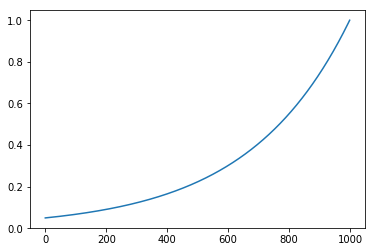

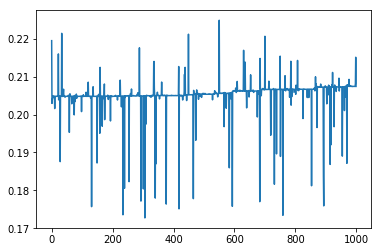

Before Cost = 78.24329376220703
After Cost = 75.21253204345703


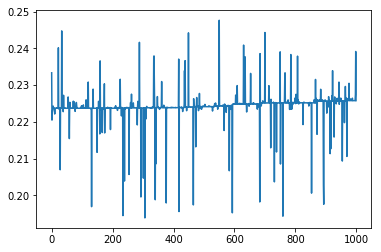

No such File
Patient 7 and dataset 4
data7_4.csv is loaded
Before Cost = 71.94147491455078
After Cost = 64.52259826660156
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 46.81399154663086
After Cost = 24.550018310546875
Patient 7 and dataset 5
data7_5.csv is loaded
Before Cost = 74.47880554199219
After Cost = 71.19192504882812
No such File
Patient 7 and dataset 6
data7_6.csv is loaded
Before Cost = 71.63267517089844
After Cost = 65.44029235839844
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 45.13824462890625
After Cost = 25.838438034057617
Patient 7 and dataset 7
data7_7.csv is loaded
Before Cost = 74.7474365234375
After Cost = 72.06494903564453
No such File
Patient 8 and dataset 1
data8_1.csv is loaded
Before Cost = 58.337928771972656
After Cost = 50.92467498779297
No such File
Patient 8 and dataset 2
data8_2.csv is loaded
Before Cost = 65.00909423828125
After Cost = 63.0059700012207
data8w.csv is loaded
Normal 8 wake_up 1
Before Cost = 49.00452423095703
After Cost = 17

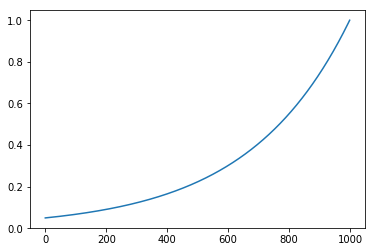

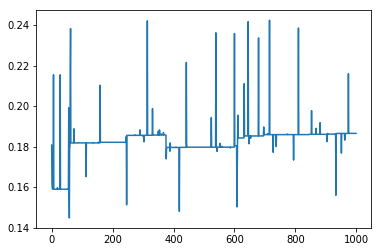

Before Cost = 82.79080963134766
After Cost = 68.0020751953125


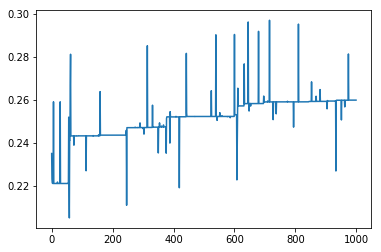

No such File
Patient 8 and dataset 12
data8_12.csv is loaded


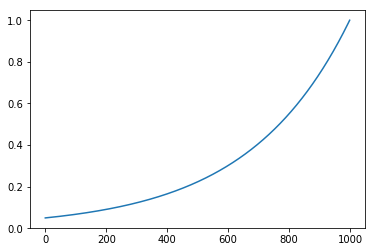

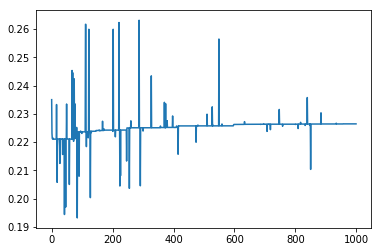

Before Cost = 74.06651306152344
After Cost = 65.03776550292969


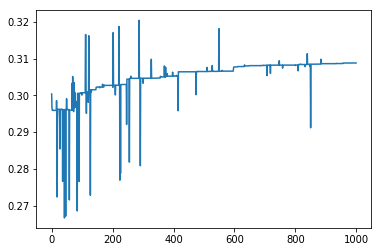

data8w.csv is loaded
Normal 8 wake_up 1


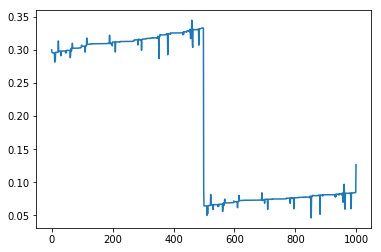

Before Cost = 52.083740234375
After Cost = 26.44695281982422


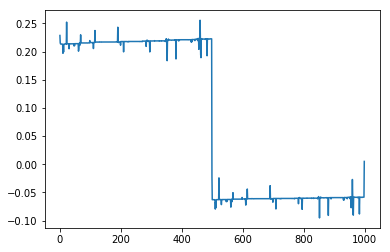

Patient 8 and dataset 13
data8_13.csv is loaded
Before Cost = 47.652015686035156
After Cost = 21.13632583618164
No such File
Patient 9 and dataset 3
data9_3.csv is loaded
Before Cost = 215.4798126220703
After Cost = 70.9144515991211
No such File
Patient 9 and dataset 4
data9_4.csv is loaded
Before Cost = 70.13436889648438
After Cost = 68.82833099365234
data9w.csv is loaded
Normal 9 wake_up 1
Before Cost = 47.36723327636719
After Cost = 7.012165069580078
Patient 9 and dataset 5
data9_5.csv is loaded
Before Cost = 132.99713134765625
After Cost = 68.39600372314453
No such File
Patient 9 and dataset 6
data9_6.csv is loaded


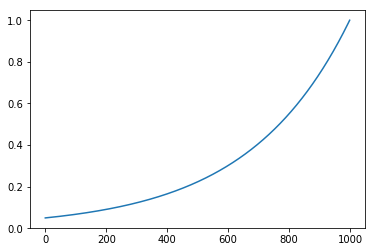

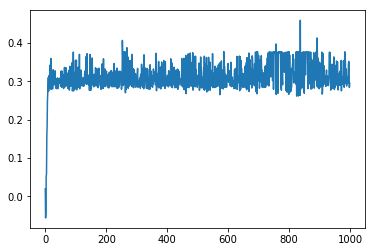

Before Cost = 62.949676513671875
After Cost = 64.07977294921875


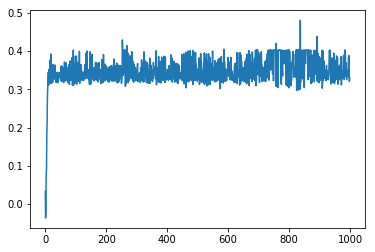

data9w.csv is loaded
Normal 9 wake_up 1


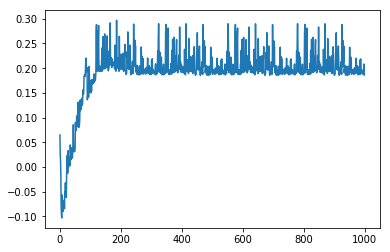

Before Cost = 39.61271286010742
After Cost = 2.994198799133301


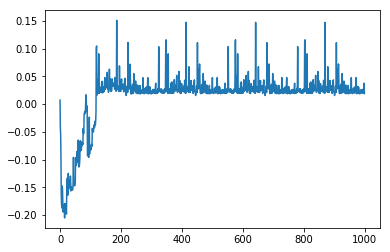

Patient 9 and dataset 7
data9_7.csv is loaded
Before Cost = 79.06629180908203
After Cost = 67.87744140625
No such File
Patient 9 and dataset 8
data9_8.csv is loaded


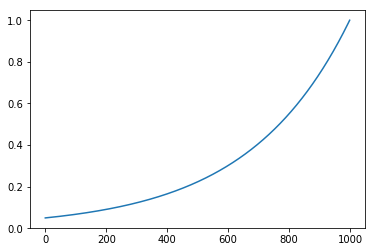

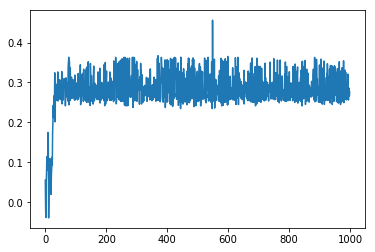

Before Cost = 67.0090560913086
After Cost = 65.87995910644531


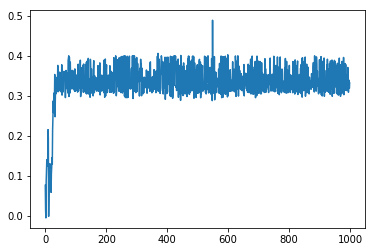

data9w.csv is loaded
Normal 9 wake_up 1


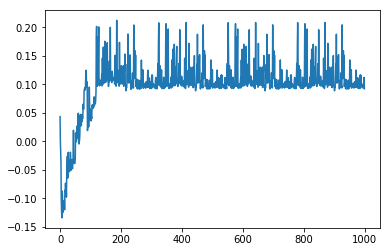

Before Cost = 11.929805755615234
After Cost = 1.71950101852417


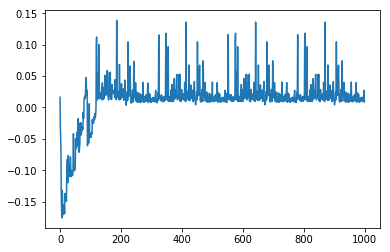

Patient 9 and dataset 10
data9_10.csv is loaded
Before Cost = 68.58499145507812
After Cost = 66.37588500976562
data9w.csv is loaded
Normal 9 wake_up 1
Before Cost = 2.0575857162475586
After Cost = 1.1410837173461914
Patient 9 and dataset 11
data9_11.csv is loaded
Before Cost = 65.48870849609375
After Cost = 65.06401062011719
No such File
Patient 9 and dataset 12
data9_12.csv is loaded
Before Cost = 63.817909240722656
After Cost = 62.56459426879883
data9w.csv is loaded
Normal 9 wake_up 1
Before Cost = 2.4476351737976074
After Cost = 1.0014231204986572
Patient 9 and dataset 13
data9_13.csv is loaded
Before Cost = 61.04576873779297
After Cost = 59.375267028808594
No such File
Patient 9 and dataset 14
data9_14.csv is loaded
Before Cost = 68.92533874511719
After Cost = 65.47639465332031
data9w.csv is loaded
Normal 9 wake_up 1
Before Cost = 1.0492037534713745
After Cost = 0.9006862640380859
Patient 9 and dataset 15
data9_15.csv is loaded
Before Cost = 64.8922119140625
After Cost = 63.6461257

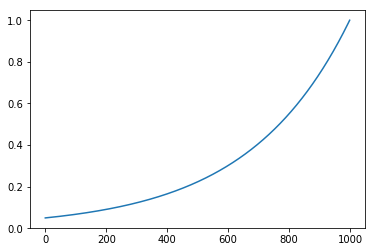

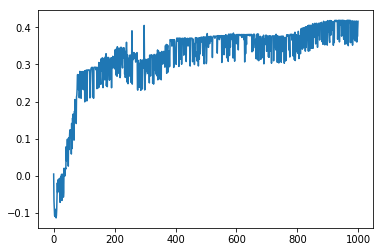

Before Cost = 47.684078216552734
After Cost = 46.41541290283203


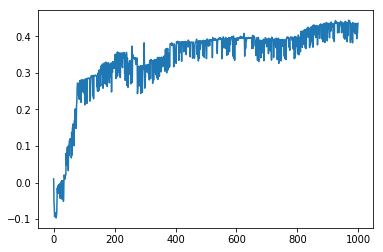

data2w.csv is loaded
Normal 2 wake_up 1


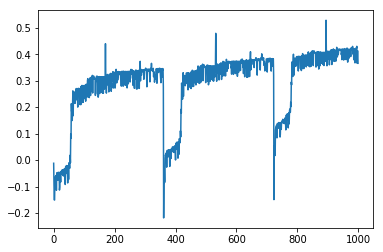

Before Cost = 101.60258483886719
After Cost = 14.282752990722656


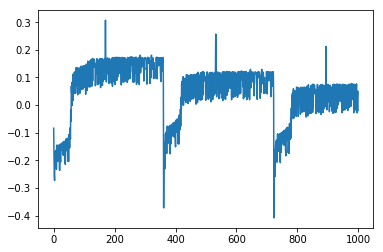

Patient 11 and dataset 3
data11_3.csv is loaded
Before Cost = 103.71868896484375
After Cost = 43.16021728515625
No such File
Patient 11 and dataset 4
data11_4.csv is loaded
Before Cost = 43.61528396606445
After Cost = 38.48365783691406
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 93.0867691040039
After Cost = 8.97088623046875
Patient 11 and dataset 5
data11_5.csv is loaded


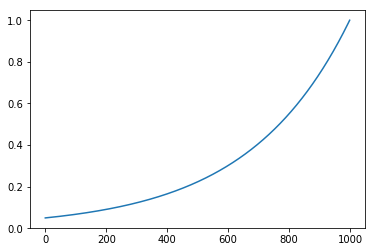

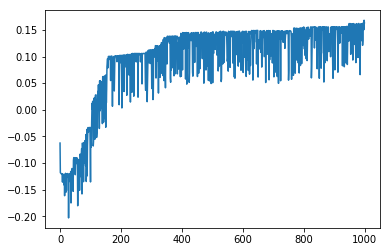

Before Cost = 102.13262176513672
After Cost = 65.27003479003906


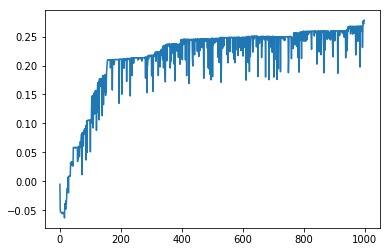

No such File
Patient 11 and dataset 6
data11_6.csv is loaded
Before Cost = 68.04995727539062
After Cost = 47.55118179321289
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 73.45513916015625
After Cost = 34.98700714111328
Patient 11 and dataset 7
data11_7.csv is loaded
Before Cost = 50.3792724609375
After Cost = 47.62761306762695
No such File
Patient 11 and dataset 8
data11_8.csv is loaded
Before Cost = 74.26114654541016
After Cost = 47.563270568847656
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 62.53471755981445
After Cost = 23.734317779541016
Patient 12 and dataset 1
data12_1.csv is loaded
Before Cost = 42.52165985107422
After Cost = 42.210567474365234
No such File
Patient 13 and dataset 1
data13_1.csv is loaded
Before Cost = 40.08098602294922
After Cost = 37.42081832885742
No such File
Patient 13 and dataset 2
data13_2.csv is loaded
Before Cost = 43.011940002441406
After Cost = 39.749393463134766
data4w.csv is loaded
Normal 4 wake_up 1
Before Cost = 9.862639427185059


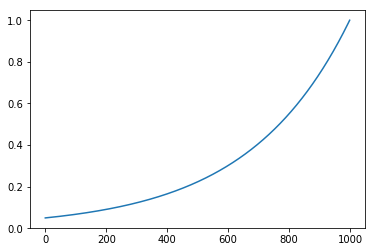

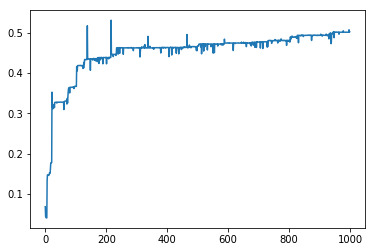

Before Cost = 71.20779418945312
After Cost = 60.058963775634766


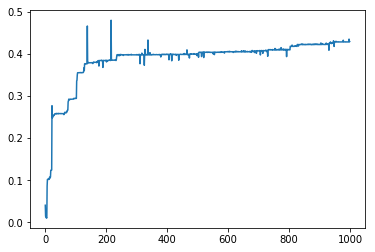

No such File
Patient 14 and dataset 2
data14_2.csv is loaded
Before Cost = 100.48094940185547
After Cost = 63.24101257324219
data5w.csv is loaded
Normal 5 wake_up 1
Before Cost = 49.08522033691406
After Cost = 27.43235969543457
Patient 14 and dataset 3
data14_3.csv is loaded
Before Cost = 60.96402359008789
After Cost = 57.701385498046875
No such File
Patient 14 and dataset 4
data14_4.csv is loaded
Before Cost = 41.41143035888672
After Cost = 36.01530456542969
data5w.csv is loaded
Normal 5 wake_up 1
Before Cost = 18.334545135498047
After Cost = 9.689519882202148
Patient 14 and dataset 5
data14_5.csv is loaded
Before Cost = 47.28805923461914
After Cost = 43.057762145996094
No such File
Patient 14 and dataset 6
data14_6.csv is loaded
Before Cost = 40.2791633605957
After Cost = 38.663116455078125
data5w.csv is loaded
Normal 5 wake_up 1
Before Cost = 7.830454349517822
After Cost = 4.92546272277832
Patient 15 and dataset 1
data15_1.csv is loaded
Before Cost = 151.56251525878906
After Cost = 

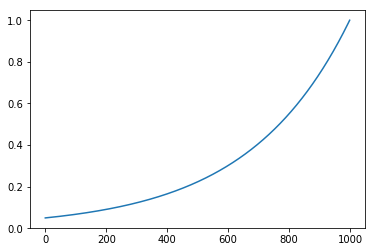

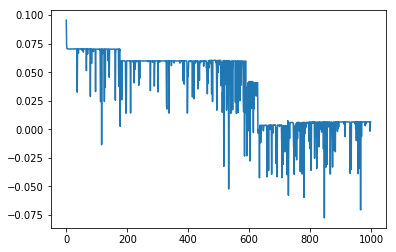

Before Cost = 159.04299926757812
After Cost = 72.7047119140625


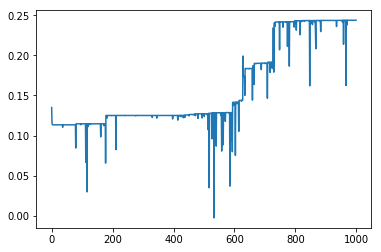

No such File
Patient 15 and dataset 14
data15_14.csv is loaded
Before Cost = 57.70441436767578
After Cost = 50.753746032714844
data6w.csv is loaded
Normal 6 wake_up 1
Before Cost = 70.24581909179688
After Cost = 21.071300506591797
Patient 15 and dataset 15
data15_15.csv is loaded
Before Cost = 91.66847229003906
After Cost = 64.4119873046875
No such File
Patient 15 and dataset 16
data15_16.csv is loaded
Before Cost = 78.43873596191406
After Cost = 69.10868072509766
data6w.csv is loaded
Normal 6 wake_up 1
Before Cost = 52.342185974121094
After Cost = 21.72769546508789
Patient 15 and dataset 18
data15_18.csv is loaded
Before Cost = 63.880027770996094
After Cost = 63.35504150390625
data6w.csv is loaded
Normal 6 wake_up 1
Before Cost = 19.687801361083984
After Cost = 14.531102180480957
Patient 15 and dataset 19
data15_19.csv is loaded
Before Cost = 57.07661056518555
After Cost = 50.02031326293945
No such File
Patient 15 and dataset 21
data15_21.csv is loaded
Before Cost = 51.49131393432617


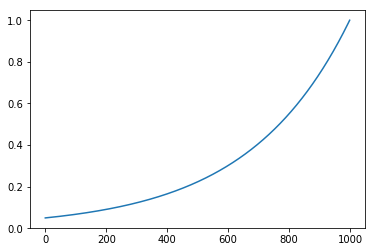

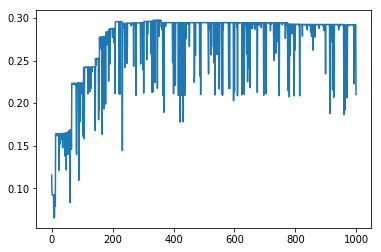

Before Cost = 62.67441940307617
After Cost = 60.30036163330078


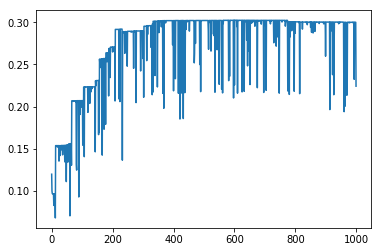

No such File
Patient 15 and dataset 29
data15_29.csv is loaded
Before Cost = 55.760231018066406
After Cost = 47.32208251953125
No such File
Patient 15 and dataset 30
data15_30.csv is loaded
Before Cost = 59.83668899536133
After Cost = 51.20787048339844
data6w.csv is loaded
Normal 6 wake_up 1
Before Cost = 35.35972595214844
After Cost = 16.259489059448242
Patient 16 and dataset 1
data16_1.csv is loaded
Before Cost = 122.56301879882812
After Cost = 88.3773193359375
No such File
Patient 16 and dataset 2
data16_2.csv is loaded
Before Cost = 74.67201232910156
After Cost = 42.50231170654297
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 71.44924926757812
After Cost = 16.749204635620117
Patient 16 and dataset 3
data16_3.csv is loaded
Before Cost = 36.63597106933594
After Cost = 28.56595230102539
No such File
Patient 16 and dataset 4
data16_4.csv is loaded
Before Cost = 38.215518951416016
After Cost = 31.707996368408203
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 17.3827209472

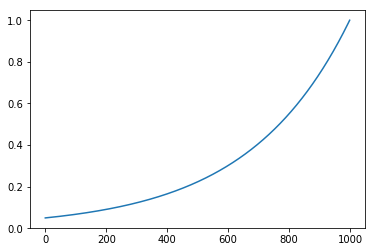

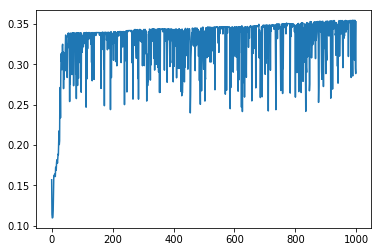

Before Cost = 63.01419448852539
After Cost = 62.357383728027344


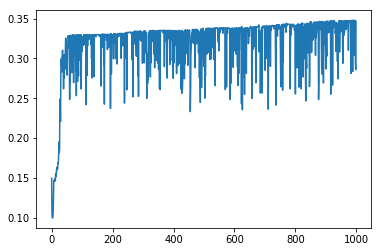

No such File
Patient 18 and dataset 3
data18_3.csv is loaded
Before Cost = 62.41749572753906
After Cost = 61.30086135864258
No such File
Patient 18 and dataset 4
data18_4.csv is loaded
Before Cost = 51.09967041015625
After Cost = 42.952972412109375
data9w.csv is loaded
Normal 9 wake_up 1
Before Cost = 92.89742279052734
After Cost = 11.083781242370605
Patient 1 and dataset 1
data1_1.csv is loaded
Before Cost = 151.52801513671875
After Cost = 89.99382019042969
No such File
Patient 1 and dataset 2
data1_2.csv is loaded
Before Cost = 105.06857299804688
After Cost = 64.78729248046875
data1w.csv is loaded
Normal 1 wake_up 1
Before Cost = 469.47332763671875
After Cost = 15.189010620117188
Patient 1 and dataset 3
data1_3.csv is loaded


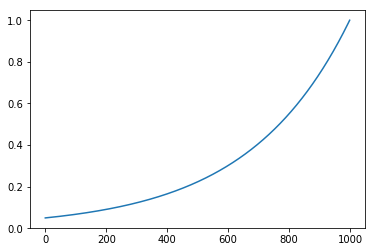

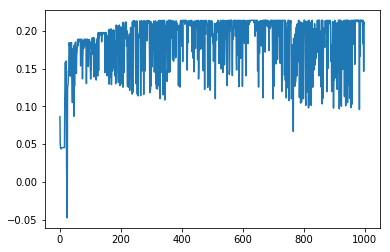

Before Cost = 83.34278869628906
After Cost = 71.00390625


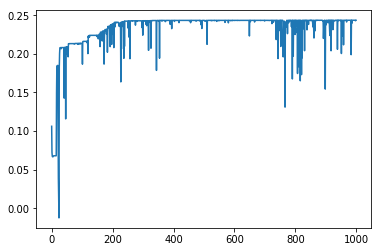

No such File
Patient 1 and dataset 4
data1_4.csv is loaded
Before Cost = 66.73455810546875
After Cost = 52.6943359375
data1w.csv is loaded
Normal 1 wake_up 1
Before Cost = 21.961589813232422
After Cost = 15.192852973937988
Patient 1 and dataset 5
data1_5.csv is loaded
Before Cost = 56.67060089111328
After Cost = 47.86481475830078
No such File
Patient 1 and dataset 6
data1_6.csv is loaded
Before Cost = 51.1127815246582
After Cost = 43.749629974365234
data1w.csv is loaded
Normal 1 wake_up 1
Before Cost = 28.845741271972656
After Cost = 15.650575637817383
Patient 1 and dataset 7
data1_7.csv is loaded
Before Cost = 53.34980773925781
After Cost = 48.086082458496094
No such File
Patient 2 and dataset 1
data2_1.csv is loaded
Before Cost = 98.67453002929688
After Cost = 76.9000244140625
No such File
Patient 2 and dataset 2
data2_2.csv is loaded


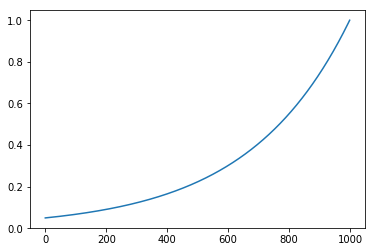

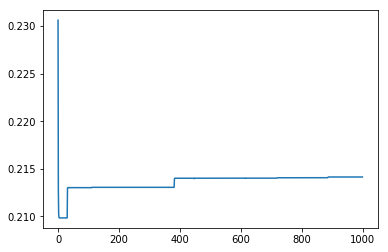

Before Cost = 76.56686401367188
After Cost = 67.36875915527344


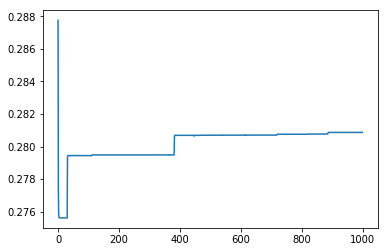

data2w.csv is loaded
Normal 2 wake_up 1


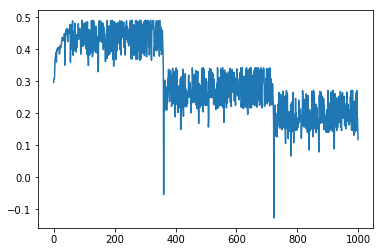

Before Cost = 105.12833404541016
After Cost = 21.95638656616211


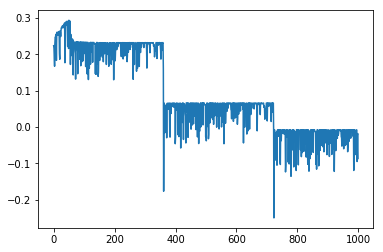

Patient 2 and dataset 3
data2_3.csv is loaded
Before Cost = 77.56944274902344
After Cost = 74.97225952148438
No such File
Patient 2 and dataset 4
data2_4.csv is loaded
Before Cost = 55.52995300292969
After Cost = 47.84117889404297
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 28.93714141845703
After Cost = 15.823123931884766
Patient 2 and dataset 5
data2_5.csv is loaded
Before Cost = 160.77880859375
After Cost = 90.14718627929688
No such File
Patient 2 and dataset 6
data2_6.csv is loaded
Before Cost = 64.51068115234375
After Cost = 49.82229232788086
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 74.05562591552734
After Cost = 20.34493637084961
Patient 2 and dataset 7
data2_7.csv is loaded
Before Cost = 91.234375
After Cost = 55.76628112792969
No such File
Patient 3 and dataset 1
data3_1.csv is loaded
Before Cost = 64.07164001464844
After Cost = 64.10791778564453
No such File
Patient 3 and dataset 5
data3_5.csv is loaded
Before Cost = 64.21632385253906
After Cost = 63.439

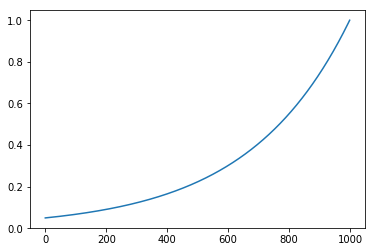

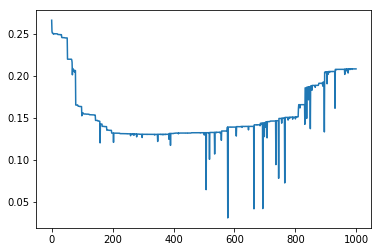

Before Cost = 86.61376190185547
After Cost = 42.701393127441406


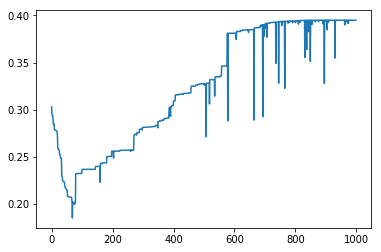

data3w.csv is loaded
Normal 3 wake_up 1


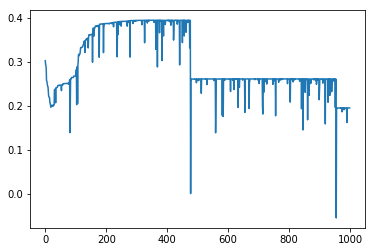

Before Cost = 93.90048217773438
After Cost = 13.80123519897461


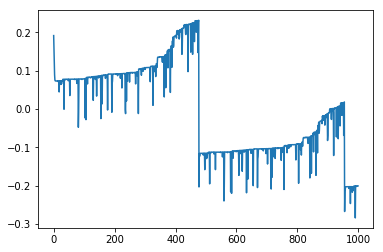

Patient 4 and dataset 1
data4_1.csv is loaded
Before Cost = 80.80577087402344
After Cost = 74.09844207763672
No such File
Patient 4 and dataset 2
data4_2.csv is loaded
Before Cost = 116.06466674804688
After Cost = 66.30793762207031
data4w.csv is loaded
Normal 4 wake_up 1
Before Cost = 69.3298110961914
After Cost = 10.182242393493652
Patient 4 and dataset 3
data4_3.csv is loaded
Before Cost = 106.47396850585938
After Cost = 66.34324645996094
No such File
Patient 5 and dataset 2
data5_2.csv is loaded
Before Cost = 68.34555053710938
After Cost = 66.26199340820312
data5w.csv is loaded
Normal 5 wake_up 1
Before Cost = 10.691872596740723
After Cost = 9.123159408569336
Patient 5 and dataset 3
data5_3.csv is loaded
Before Cost = 102.927001953125
After Cost = 77.58287048339844
No such File
Patient 5 and dataset 4
data5_4.csv is loaded
Before Cost = 69.47844696044922
After Cost = 68.10499572753906
data5w.csv is loaded
Normal 5 wake_up 1
Before Cost = 18.701885223388672
After Cost = 9.31029510498

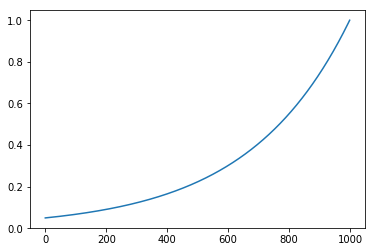

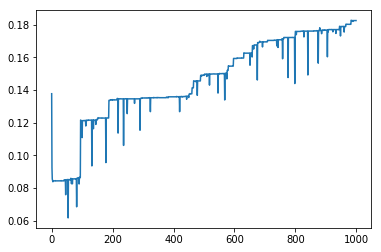

Before Cost = 84.54696655273438
After Cost = 53.49126434326172


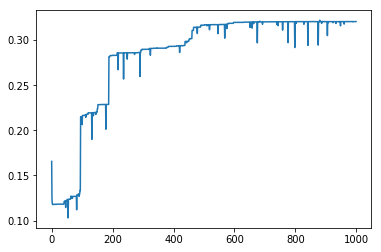

No such File
Patient 8 and dataset 1
data8_1.csv is loaded
Before Cost = 60.19380569458008
After Cost = 60.165340423583984
No such File
Patient 8 and dataset 2
data8_2.csv is loaded
Before Cost = 50.693634033203125
After Cost = 44.65086364746094
data8w.csv is loaded
Normal 8 wake_up 1
Before Cost = 12.164947509765625
After Cost = 9.673702239990234
Patient 8 and dataset 3
data8_3.csv is loaded
Before Cost = 53.48872375488281
After Cost = 48.17528533935547
No such File
Patient 8 and dataset 4
data8_4.csv is loaded
Before Cost = 66.82442474365234
After Cost = 41.089744567871094
data8w.csv is loaded
Normal 8 wake_up 1
Before Cost = 17.208789825439453
After Cost = 12.5197114944458
Patient 8 and dataset 5
data8_5.csv is loaded


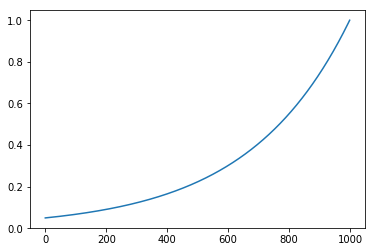

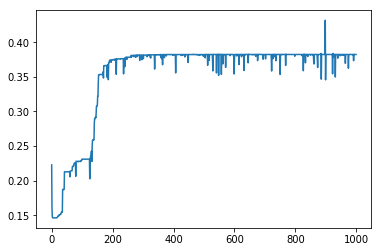

Before Cost = 57.72885513305664
After Cost = 53.50593566894531


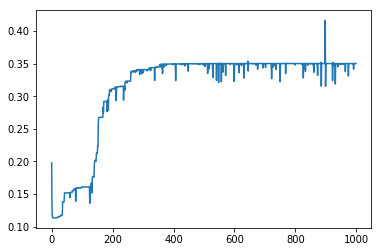

No such File
Patient 8 and dataset 6
data8_6.csv is loaded
Before Cost = 70.94475555419922
After Cost = 41.158451080322266
data8w.csv is loaded
Normal 8 wake_up 1
Before Cost = 18.876718521118164
After Cost = 12.073112487792969
Patient 8 and dataset 7
data8_7.csv is loaded
Before Cost = 64.77484893798828
After Cost = 41.144588470458984
No such File
Patient 8 and dataset 9
data8_9.csv is loaded
Before Cost = 53.04454040527344
After Cost = 39.02386474609375
No such File
Patient 8 and dataset 10
data8_10.csv is loaded
Before Cost = 91.4917221069336
After Cost = 74.17472839355469
data8w.csv is loaded
Normal 8 wake_up 1
Before Cost = 26.986526489257812
After Cost = 19.37125015258789
Patient 8 and dataset 11
data8_11.csv is loaded
Before Cost = 75.35513305664062
After Cost = 58.6143913269043
No such File
Patient 8 and dataset 12
data8_12.csv is loaded
Before Cost = 66.34485626220703
After Cost = 52.72899627685547
data8w.csv is loaded
Normal 8 wake_up 1
Before Cost = 50.854576110839844
After 

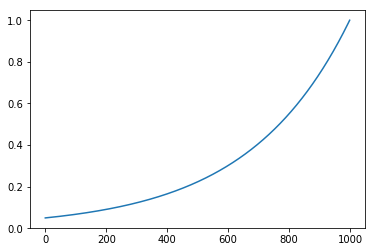

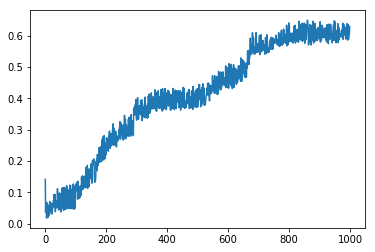

Before Cost = 28.542491912841797
After Cost = 21.389995574951172


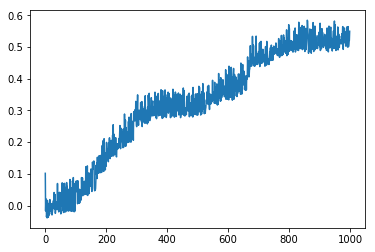

No such File
Patient 9 and dataset 14
data9_14.csv is loaded
Before Cost = 52.44171905517578
After Cost = 24.333480834960938
data9w.csv is loaded
Normal 9 wake_up 1
Before Cost = 3.462864398956299
After Cost = 2.9694395065307617
Patient 9 and dataset 15
data9_15.csv is loaded
Before Cost = 122.76302337646484
After Cost = 57.65293502807617
No such File
Patient 9 and dataset 16
data9_16.csv is loaded
Before Cost = 118.05264282226562
After Cost = 18.36675453186035
data9w.csv is loaded
Normal 9 wake_up 1
Before Cost = 3.1139676570892334
After Cost = 1.6396251916885376
Patient 11 and dataset 1
data11_1.csv is loaded
Before Cost = 57.44695281982422
After Cost = 37.35197830200195
No such File
Patient 11 and dataset 2
data11_2.csv is loaded
Before Cost = 46.64669418334961
After Cost = 35.312461853027344
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 16.201610565185547
After Cost = 4.144270420074463
Patient 11 and dataset 3
data11_3.csv is loaded
Before Cost = 27.17072105407715
After Cos

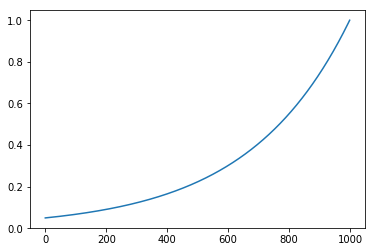

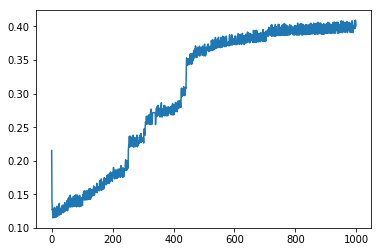

Before Cost = 36.740482330322266
After Cost = 34.79416275024414


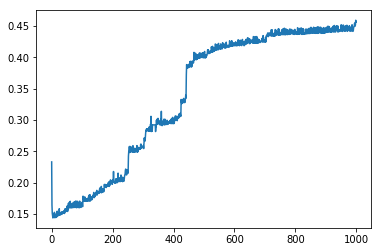

data2w.csv is loaded
Normal 2 wake_up 1


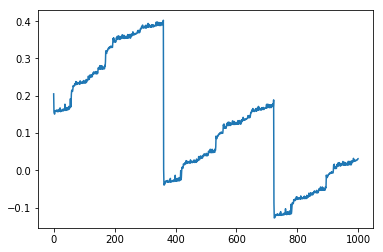

Before Cost = 39.575408935546875
After Cost = 7.090445518493652


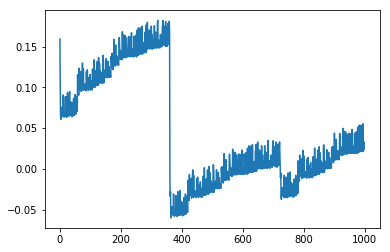

Patient 11 and dataset 7
data11_7.csv is loaded
Before Cost = 96.94674682617188
After Cost = 36.407562255859375
No such File
Patient 11 and dataset 8
data11_8.csv is loaded
Before Cost = 175.23428344726562
After Cost = 46.0929069519043
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 11.557674407958984
After Cost = 13.895490646362305
Patient 12 and dataset 1
data12_1.csv is loaded
Before Cost = 56.98421859741211
After Cost = 35.32971954345703
No such File
Patient 13 and dataset 1
data13_1.csv is loaded
Before Cost = 74.94760131835938
After Cost = 40.320579528808594
No such File
Patient 13 and dataset 2
data13_2.csv is loaded
Before Cost = 35.96072006225586
After Cost = 24.48493766784668
data4w.csv is loaded
Normal 4 wake_up 1
Before Cost = 39.829105377197266
After Cost = 7.33390474319458
Patient 13 and dataset 3
data13_3.csv is loaded
Before Cost = 86.45720672607422
After Cost = 57.19003677368164
No such File
Patient 14 and dataset 1
data14_1.csv is loaded


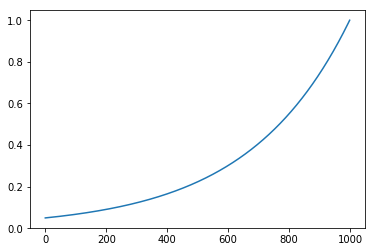

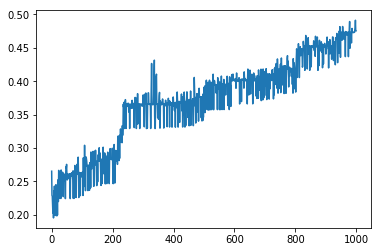

Before Cost = 44.53622055053711
After Cost = 43.522605895996094


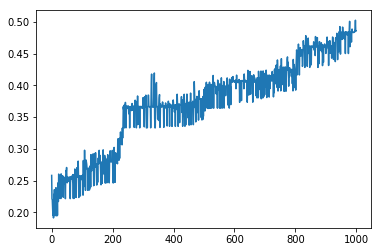

No such File
Patient 14 and dataset 2
data14_2.csv is loaded
Before Cost = 179.58474731445312
After Cost = 67.40199279785156
data5w.csv is loaded
Normal 5 wake_up 1
Before Cost = 1.2223827838897705
After Cost = 1.1127610206604004
Patient 14 and dataset 3
data14_3.csv is loaded
Before Cost = 70.81924438476562
After Cost = 57.33513641357422
No such File
Patient 14 and dataset 4
data14_4.csv is loaded
Before Cost = 36.39712142944336
After Cost = 30.942337036132812
data5w.csv is loaded
Normal 5 wake_up 1
Before Cost = 1.300441026687622
After Cost = 1.2293087244033813
Patient 14 and dataset 5
data14_5.csv is loaded
Before Cost = 51.92579650878906
After Cost = 41.504180908203125
No such File
Patient 14 and dataset 6
data14_6.csv is loaded
Before Cost = 42.71548080444336
After Cost = 35.10358428955078
data5w.csv is loaded
Normal 5 wake_up 1
Before Cost = 0.956403374671936
After Cost = 0.6645933389663696
Patient 15 and dataset 1
data15_1.csv is loaded
Before Cost = 145.346435546875
After Cost 

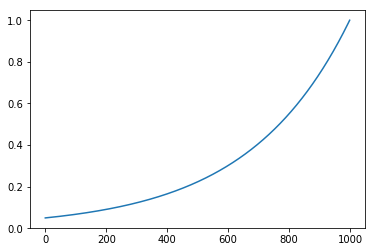

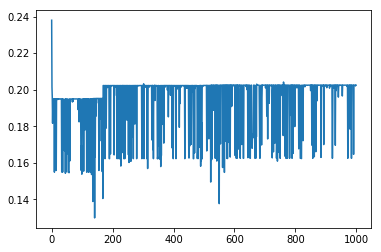

Before Cost = 80.16825866699219
After Cost = 66.20465087890625


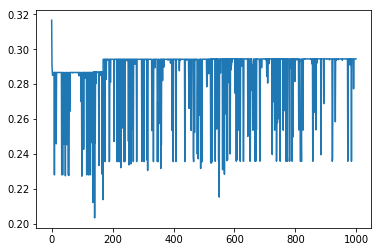

data6w.csv is loaded
Normal 6 wake_up 1


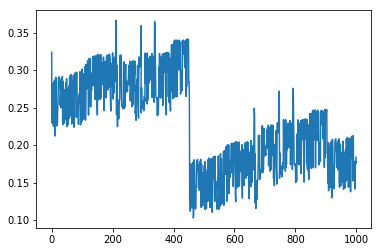

Before Cost = 55.772125244140625
After Cost = 21.567468643188477


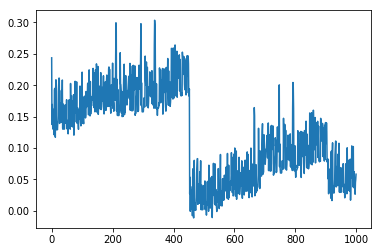

Patient 15 and dataset 15
data15_15.csv is loaded
Before Cost = 81.43537902832031
After Cost = 75.1588134765625
No such File
Patient 15 and dataset 16
data15_16.csv is loaded


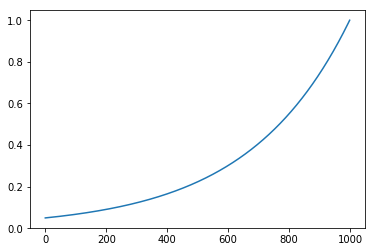

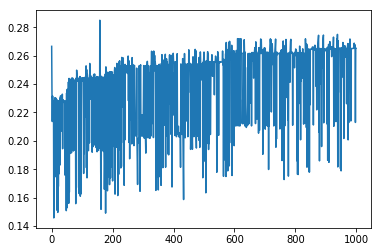

Before Cost = 67.32698059082031
After Cost = 59.905914306640625


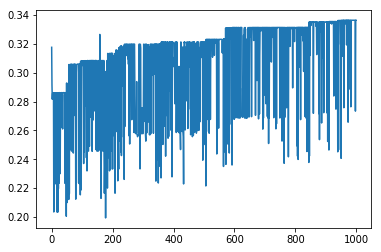

data6w.csv is loaded
Normal 6 wake_up 1


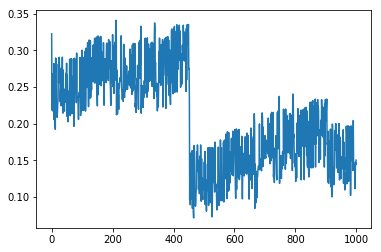

Before Cost = 46.97968292236328
After Cost = 15.747835159301758


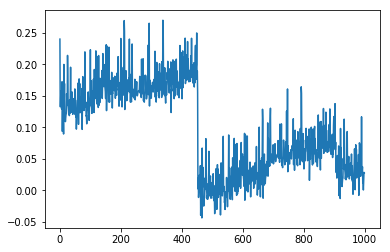

Patient 15 and dataset 18
data15_18.csv is loaded
Before Cost = 77.0295181274414
After Cost = 69.43220520019531
data6w.csv is loaded
Normal 6 wake_up 1
Before Cost = 23.03126335144043
After Cost = 10.270875930786133
Patient 15 and dataset 19
data15_19.csv is loaded
Before Cost = 95.125
After Cost = 73.29977416992188
No such File
Patient 15 and dataset 21
data15_21.csv is loaded
Before Cost = 74.0974349975586
After Cost = 67.53413391113281
No such File
Patient 15 and dataset 22
data15_22.csv is loaded
Before Cost = 65.38806915283203
After Cost = 65.04209899902344
data6w.csv is loaded
Normal 6 wake_up 1
Before Cost = 57.12608337402344
After Cost = 18.342662811279297
Patient 15 and dataset 23
data15_23.csv is loaded
Before Cost = 82.9737548828125
After Cost = 77.82433319091797
No such File
Patient 15 and dataset 24
data15_24.csv is loaded
Before Cost = 71.74854278564453
After Cost = 64.35932159423828
data6w.csv is loaded
Normal 6 wake_up 1
Before Cost = 43.68817901611328
After Cost = 15.5

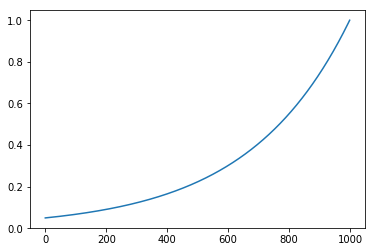

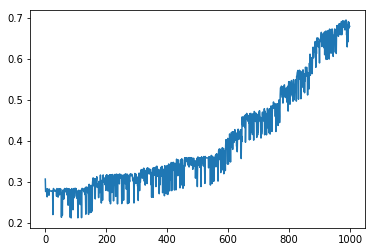

Before Cost = 24.617679595947266
After Cost = 17.34201431274414


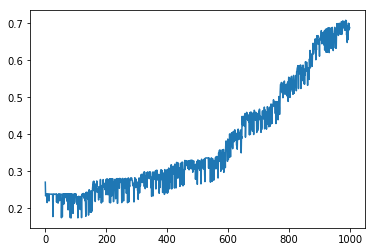

data9w.csv is loaded
Normal 9 wake_up 1


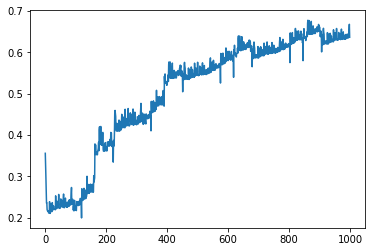

Before Cost = 270.54693603515625
After Cost = 12.858373641967773


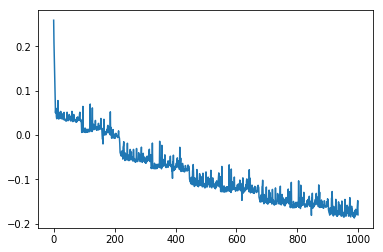

Patient 1 and dataset 1
data1_1.csv is loaded
Before Cost = 122.68453979492188
After Cost = 78.15538024902344
No such File
Patient 1 and dataset 2
data1_2.csv is loaded


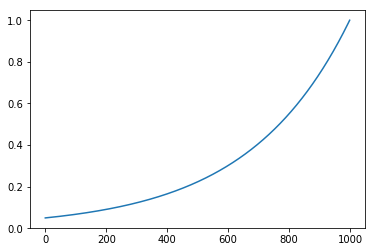

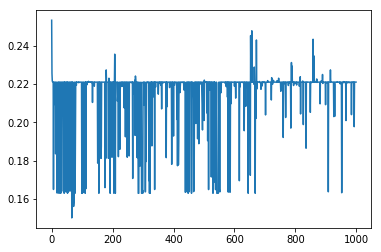

Before Cost = 75.01412200927734
After Cost = 61.31856155395508


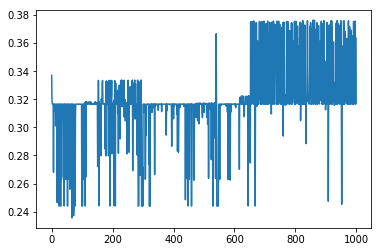

data1w.csv is loaded
Normal 1 wake_up 1


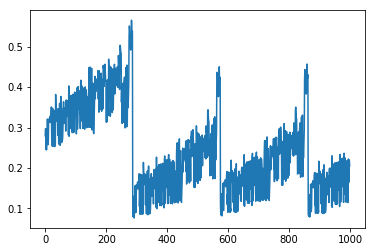

Before Cost = 71.45150756835938
After Cost = 14.404136657714844


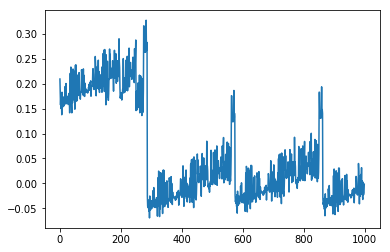

Patient 1 and dataset 3
data1_3.csv is loaded
Before Cost = 78.25460052490234
After Cost = 73.23500061035156
No such File
Patient 1 and dataset 4
data1_4.csv is loaded
Before Cost = 74.10934448242188
After Cost = 67.00732421875
data1w.csv is loaded
Normal 1 wake_up 1
Before Cost = 28.88355827331543
After Cost = 13.947500228881836
Patient 1 and dataset 5
data1_5.csv is loaded
Before Cost = 76.85720825195312
After Cost = 74.25022888183594
No such File
Patient 1 and dataset 6
data1_6.csv is loaded
Before Cost = 69.76205444335938
After Cost = 64.5289535522461
data1w.csv is loaded
Normal 1 wake_up 1
Before Cost = 24.57008934020996
After Cost = 13.517513275146484
Patient 1 and dataset 7
data1_7.csv is loaded
Before Cost = 71.26210021972656
After Cost = 61.99689865112305
No such File
Patient 2 and dataset 1
data2_1.csv is loaded
Before Cost = 67.41875457763672
After Cost = 66.16070556640625
No such File
Patient 2 and dataset 2
data2_2.csv is loaded
Before Cost = 66.12797546386719
After Cost =

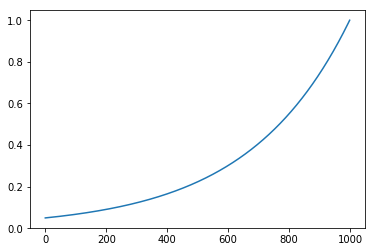

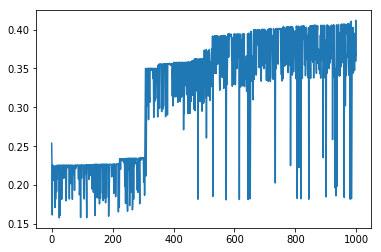

Before Cost = 48.52596664428711
After Cost = 45.712501525878906


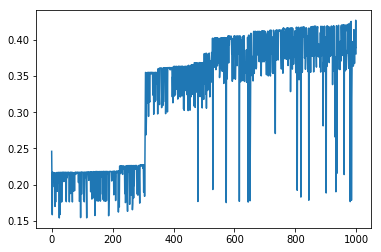

data7w.csv is loaded
Normal 7 wake_up 1


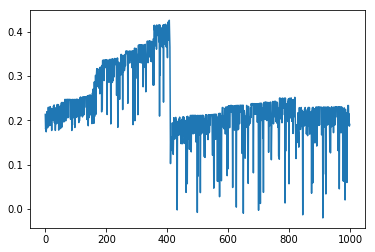

Before Cost = 60.9287223815918
After Cost = 9.288178443908691


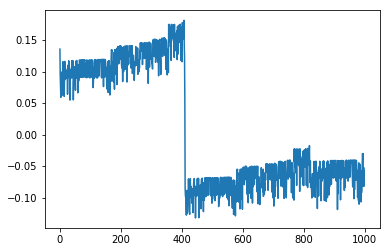

Patient 7 and dataset 3
data7_3.csv is loaded
Before Cost = 102.3166732788086
After Cost = 50.265403747558594
No such File
Patient 7 and dataset 4
data7_4.csv is loaded
Before Cost = 50.6317024230957
After Cost = 49.84735870361328
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 24.93252182006836
After Cost = 10.45407772064209
Patient 7 and dataset 5
data7_5.csv is loaded
Before Cost = 52.589683532714844
After Cost = 43.264373779296875
No such File
Patient 7 and dataset 6
data7_6.csv is loaded
Before Cost = 73.2704849243164
After Cost = 48.85527801513672
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 35.49861145019531
After Cost = 10.837472915649414
Patient 7 and dataset 7
data7_7.csv is loaded
Before Cost = 98.06704711914062
After Cost = 47.6854362487793
No such File
Patient 8 and dataset 1
data8_1.csv is loaded
Before Cost = 74.98363494873047
After Cost = 62.0075569152832
No such File
Patient 8 and dataset 2
data8_2.csv is loaded
Before Cost = 41.917171478271484
After Cos

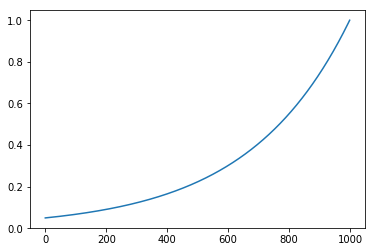

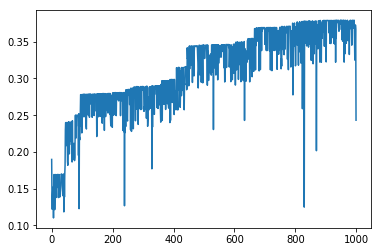

Before Cost = 47.992279052734375
After Cost = 46.812416076660156


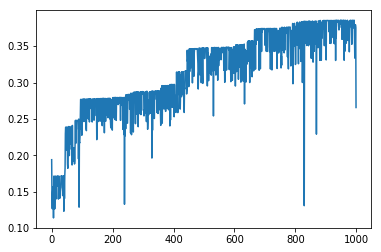

No such File
Patient 8 and dataset 4
data8_4.csv is loaded
Before Cost = 38.88621139526367
After Cost = 26.18027687072754
data8w.csv is loaded
Normal 8 wake_up 1
Before Cost = 21.175989151000977
After Cost = 13.237237930297852
Patient 8 and dataset 5
data8_5.csv is loaded
Before Cost = 56.654361724853516
After Cost = 33.178871154785156
No such File
Patient 8 and dataset 6
data8_6.csv is loaded
Before Cost = 52.926414489746094
After Cost = 47.9030647277832
data8w.csv is loaded
Normal 8 wake_up 1
Before Cost = 11.261363983154297
After Cost = 7.3036909103393555
Patient 8 and dataset 7
data8_7.csv is loaded
Before Cost = 75.15740203857422
After Cost = 42.49597930908203
No such File
Patient 8 and dataset 9
data8_9.csv is loaded
Before Cost = 30.68391227722168
After Cost = 28.298583984375
No such File
Patient 8 and dataset 10
data8_10.csv is loaded
Before Cost = 52.66312026977539
After Cost = 44.199920654296875
data8w.csv is loaded
Normal 8 wake_up 1
Before Cost = 47.812110900878906
After Co

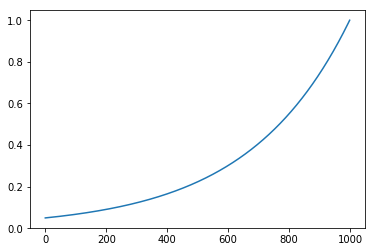

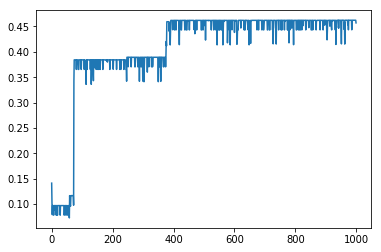

Before Cost = 59.484107971191406
After Cost = 46.633575439453125


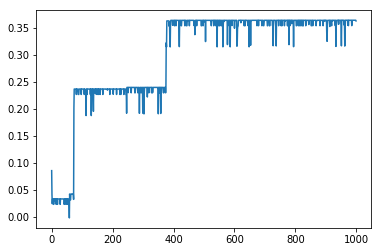

No such File
Patient 8 and dataset 12
data8_12.csv is loaded


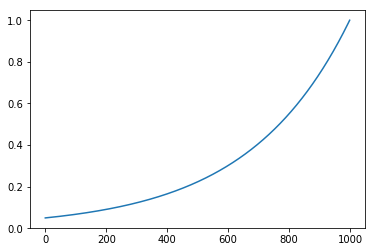

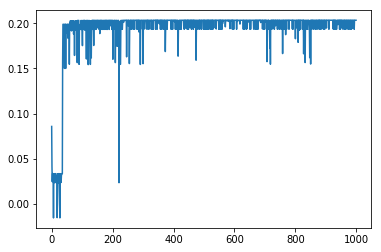

Before Cost = 78.73516845703125
After Cost = 63.358978271484375


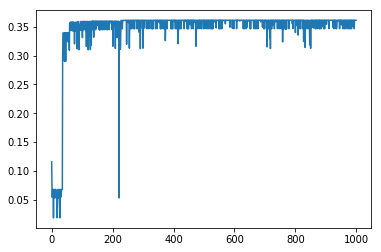

data8w.csv is loaded
Normal 8 wake_up 1


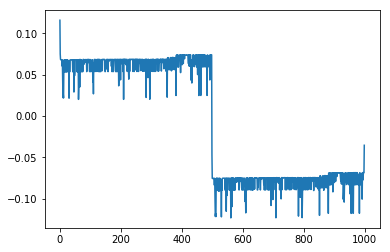

Before Cost = 5.298704624176025
After Cost = 2.7748544216156006


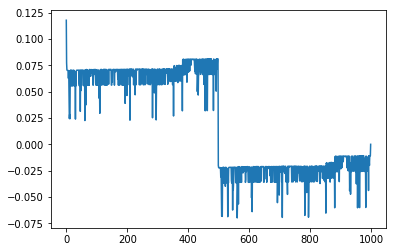

Patient 8 and dataset 13
data8_13.csv is loaded
Before Cost = 76.23150634765625
After Cost = 65.43425750732422
No such File
Patient 9 and dataset 3
data9_3.csv is loaded
Before Cost = 55.414405822753906
After Cost = 37.578086853027344
No such File
Patient 9 and dataset 4
data9_4.csv is loaded
Before Cost = 36.815467834472656
After Cost = 19.5799560546875
data9w.csv is loaded
Normal 9 wake_up 1
Before Cost = 6.701528549194336
After Cost = 4.006241798400879
Patient 9 and dataset 5
data9_5.csv is loaded


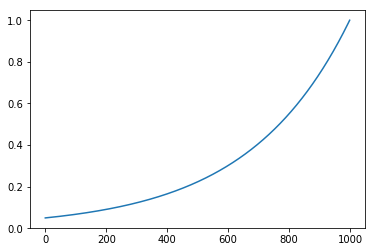

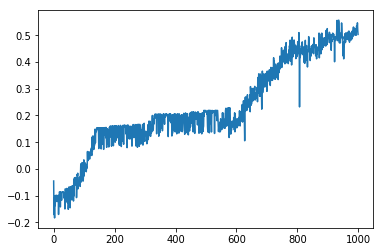

Before Cost = 22.905851364135742
After Cost = 11.009976387023926


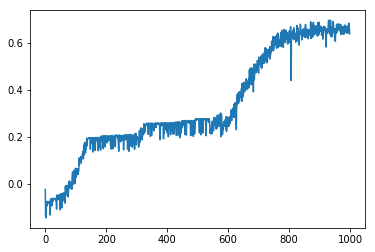

No such File
Patient 9 and dataset 6
data9_6.csv is loaded
Before Cost = 114.2645492553711
After Cost = 53.464881896972656
data9w.csv is loaded
Normal 9 wake_up 1
Before Cost = 2.932734966278076
After Cost = 2.369075298309326
Patient 9 and dataset 7
data9_7.csv is loaded
Before Cost = 46.626434326171875
After Cost = 36.478694915771484
No such File
Patient 9 and dataset 8
data9_8.csv is loaded
Before Cost = 41.90763854980469
After Cost = 35.18376159667969
data9w.csv is loaded
Normal 9 wake_up 1
Before Cost = 8.759780883789062
After Cost = 1.7281267642974854
Patient 9 and dataset 10
data9_10.csv is loaded
Before Cost = 40.19697189331055
After Cost = 34.63027572631836
data9w.csv is loaded
Normal 9 wake_up 1
Before Cost = 2.0128092765808105
After Cost = 1.4759174585342407
Patient 9 and dataset 11
data9_11.csv is loaded


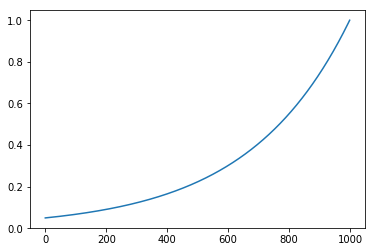

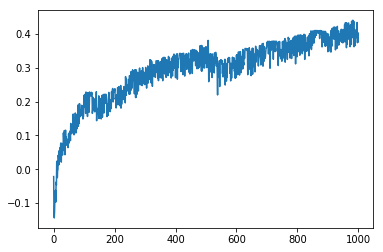

Before Cost = 39.59830856323242
After Cost = 34.373939514160156


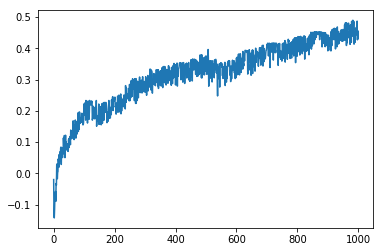

No such File
Patient 9 and dataset 12
data9_12.csv is loaded
Before Cost = 58.843387603759766
After Cost = 26.332447052001953
data9w.csv is loaded
Normal 9 wake_up 1
Before Cost = 13.144814491271973
After Cost = 2.1317152976989746
Patient 9 and dataset 13
data9_13.csv is loaded
Before Cost = 33.76879119873047
After Cost = 20.110050201416016
No such File
Patient 9 and dataset 14
data9_14.csv is loaded


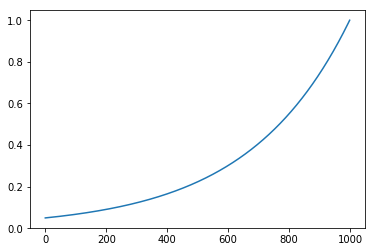

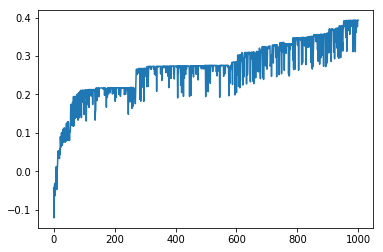

Before Cost = 44.727073669433594
After Cost = 34.91329574584961


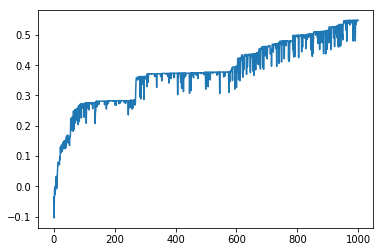

data9w.csv is loaded
Normal 9 wake_up 1


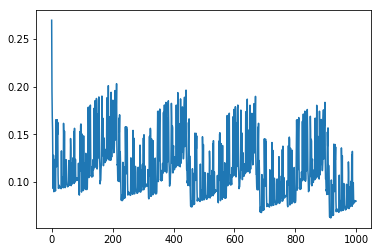

Before Cost = 13.814586639404297
After Cost = 3.2884182929992676


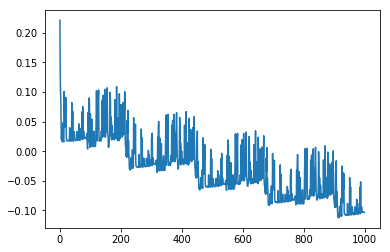

Patient 9 and dataset 15
data9_15.csv is loaded
Before Cost = 81.4150161743164
After Cost = 33.48802947998047
No such File
Patient 9 and dataset 16
data9_16.csv is loaded
Before Cost = 163.757568359375
After Cost = 27.14984130859375
data9w.csv is loaded
Normal 9 wake_up 1
Before Cost = 13.6822509765625
After Cost = 6.746469497680664
Patient 11 and dataset 1
data11_1.csv is loaded
Before Cost = 25.389636993408203
After Cost = 20.993871688842773
No such File
Patient 11 and dataset 2
data11_2.csv is loaded
Before Cost = 39.670162200927734
After Cost = 32.39301300048828
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 23.485626220703125
After Cost = 15.736495971679688
Patient 11 and dataset 3
data11_3.csv is loaded
Before Cost = 33.46831512451172
After Cost = 18.627338409423828
No such File
Patient 11 and dataset 4
data11_4.csv is loaded
Before Cost = 27.345796585083008
After Cost = 18.351394653320312
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 14.322061538696289
After Cost 

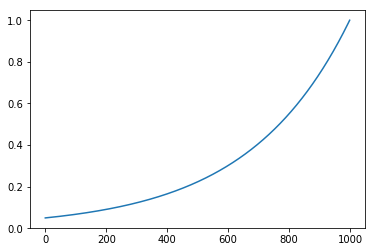

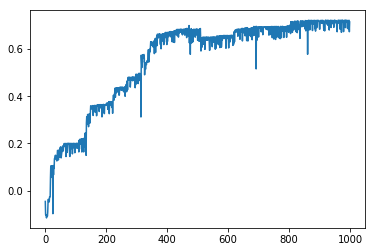

Before Cost = 92.83866882324219
After Cost = 25.124746322631836


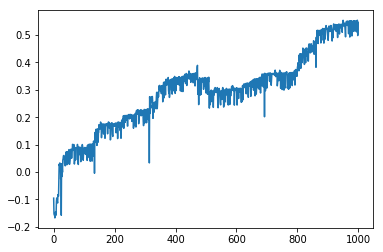

No such File
Patient 11 and dataset 8
data11_8.csv is loaded
Before Cost = 111.40995788574219
After Cost = 31.888858795166016
data2w.csv is loaded
Normal 2 wake_up 1
Before Cost = 20.599605560302734
After Cost = 12.23529052734375
Patient 12 and dataset 1
data12_1.csv is loaded
Before Cost = 119.31942749023438
After Cost = 31.810487747192383
No such File
Patient 13 and dataset 1
data13_1.csv is loaded
Before Cost = 53.785438537597656
After Cost = 24.387935638427734
No such File
Patient 13 and dataset 2
data13_2.csv is loaded
Before Cost = 32.24140930175781
After Cost = 21.435482025146484
data4w.csv is loaded
Normal 4 wake_up 1
Before Cost = 6.561519622802734
After Cost = 3.9701759815216064
Patient 13 and dataset 3
data13_3.csv is loaded
Before Cost = 104.93550109863281
After Cost = 47.257286071777344
No such File
Patient 14 and dataset 1
data14_1.csv is loaded
Before Cost = 36.19353485107422
After Cost = 24.729331970214844
No such File
Patient 14 and dataset 2
data14_2.csv is loaded
Bef

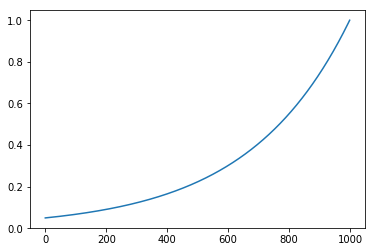

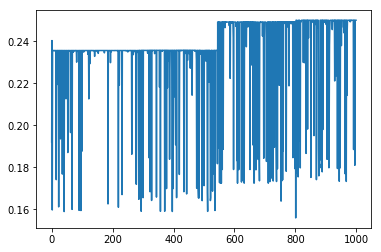

Before Cost = 71.81067657470703
After Cost = 58.4365234375


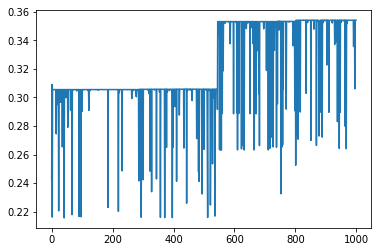

No such File
Patient 15 and dataset 22
data15_22.csv is loaded
Before Cost = 65.3121566772461
After Cost = 65.00038146972656
data6w.csv is loaded
Normal 6 wake_up 1
Before Cost = 101.29572296142578
After Cost = 23.02359962463379
Patient 15 and dataset 23
data15_23.csv is loaded
Before Cost = 43.20075607299805
After Cost = 40.734642028808594
No such File
Patient 15 and dataset 24
data15_24.csv is loaded
Before Cost = 134.687744140625
After Cost = 57.12419128417969
data6w.csv is loaded
Normal 6 wake_up 1
Before Cost = 25.669687271118164
After Cost = 13.754404067993164
Patient 15 and dataset 25
data15_25.csv is loaded
Before Cost = 49.303062438964844
After Cost = 36.893795013427734
No such File
Patient 15 and dataset 26
data15_26.csv is loaded
Before Cost = 58.84736251831055
After Cost = 58.62621307373047
data6w.csv is loaded
Normal 6 wake_up 1
Before Cost = 33.07490158081055
After Cost = 14.389846801757812
Patient 15 and dataset 27
data15_27.csv is loaded


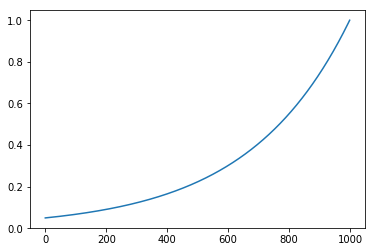

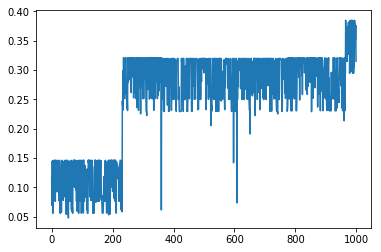

Before Cost = 55.35038757324219
After Cost = 50.60997772216797


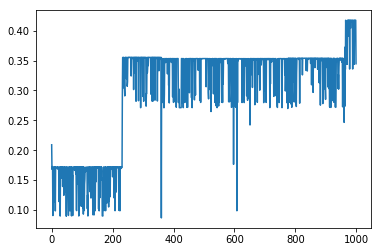

No such File
Patient 15 and dataset 29
data15_29.csv is loaded
Before Cost = 66.58122253417969
After Cost = 43.047027587890625
No such File
Patient 15 and dataset 30
data15_30.csv is loaded


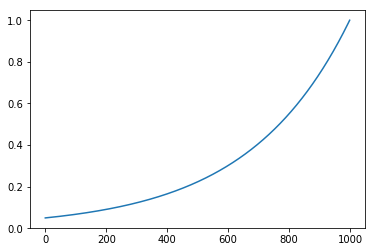

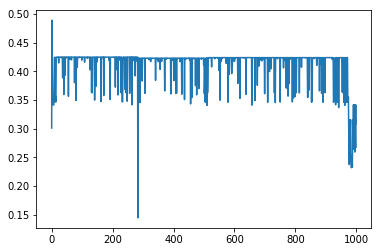

Before Cost = 81.44009399414062
After Cost = 69.16091918945312


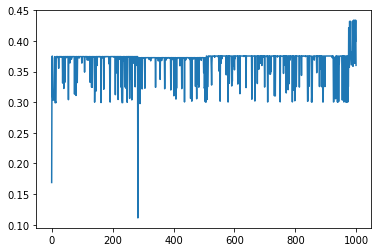

data6w.csv is loaded
Normal 6 wake_up 1


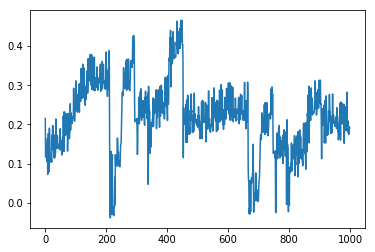

Before Cost = 54.516357421875
After Cost = 10.345893859863281


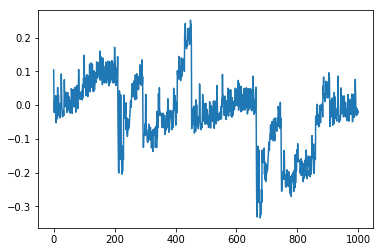

Patient 16 and dataset 1
data16_1.csv is loaded
Before Cost = 68.10890197753906
After Cost = 56.28293991088867
No such File
Patient 16 and dataset 2
data16_2.csv is loaded
Before Cost = 51.25748062133789
After Cost = 31.48926544189453
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 3.079245090484619
After Cost = 1.9104207754135132
Patient 16 and dataset 3
data16_3.csv is loaded
Before Cost = 44.878292083740234
After Cost = 17.582225799560547
No such File
Patient 16 and dataset 4
data16_4.csv is loaded
Before Cost = 39.64350509643555
After Cost = 16.952972412109375
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 10.269309997558594
After Cost = 0.8017282485961914
Patient 16 and dataset 5
data16_5.csv is loaded
Before Cost = 125.87008666992188
After Cost = 49.91387176513672
No such File
Patient 16 and dataset 6
data16_6.csv is loaded
Before Cost = 76.96456909179688
After Cost = 48.90087127685547
data7w.csv is loaded
Normal 7 wake_up 1
Before Cost = 3.2340810298919678
After Cos

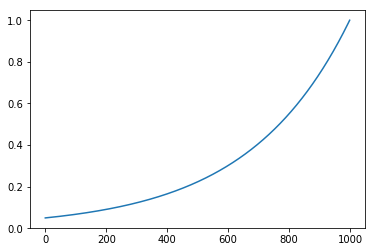

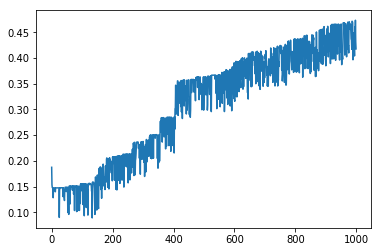

Before Cost = 31.694061279296875
After Cost = 26.815460205078125


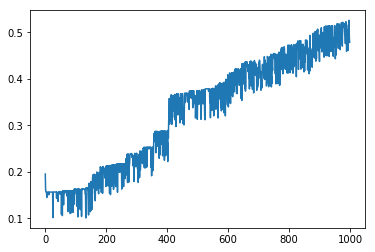

data9w.csv is loaded
Normal 9 wake_up 1


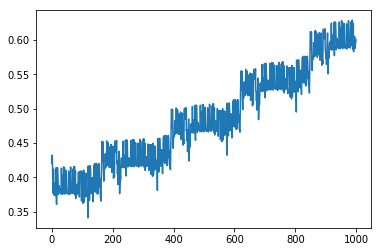

Before Cost = 239.7808380126953
After Cost = 4.964076042175293


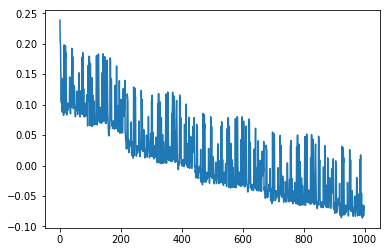

Patient 1 and dataset 1
data1_1.csv is loaded
Before Cost = 97.66847229003906
After Cost = 60.791507720947266
No such File
Patient 1 and dataset 2
data1_2.csv is loaded
Before Cost = 55.85047912597656
After Cost = 33.92655563354492
data1w.csv is loaded
Normal 1 wake_up 1
Before Cost = 71.16044616699219
After Cost = 16.691593170166016
Patient 1 and dataset 3
data1_3.csv is loaded
Before Cost = 65.96761322021484
After Cost = 67.77240753173828
No such File
Patient 1 and dataset 4
data1_4.csv is loaded
Before Cost = 63.35377502441406
After Cost = 50.600521087646484
data1w.csv is loaded
Normal 1 wake_up 1
Before Cost = 22.67725372314453
After Cost = 15.257732391357422
Patient 1 and dataset 5
data1_5.csv is loaded
Before Cost = 72.65576934814453
After Cost = 69.3563003540039
No such File
Patient 1 and dataset 6
data1_6.csv is loaded
Before Cost = 46.256011962890625
After Cost = 41.42137145996094
data1w.csv is loaded
Normal 1 wake_up 1
Before Cost = 25.962644577026367
After Cost = 15.84722614

In [ ]:
iteration=100
for s in range(iteration):
    for i in range(len(onset_times)):
        for j in range(len(onset_times[i])):
            if len(onset_times[i][j])>1:
                continue;
            onset_time_temp = onset_times[i][j][0]
            if onset_time_temp*sampling_rate/striding < train_length:
                continue;
            print("Patient {} and dataset {}".format(i+1,j+1))
            result = train_set_generator(i+1, j+1)
            input_data = result['input']
            output_data = result['output']
            
            
            probability = random.random()
            
            if probability<0.1:
                plt.plot(output_data)
                plt.show()
                plt.plot(sess.run(temp_outputs, feed_dict = {x : input_data}))
                plt.show()
            
            for k in range(20):
                opt, c = sess.run([train, cost], feed_dict={x: input_data, y: output_data})
                if k==0:
                    print("Before Cost = {}".format(c))
            print("After Cost = {}".format(c))
            
            if probability<0.1:
                plt.plot(sess.run(temp_outputs, feed_dict = {x : input_data}))
                plt.show()
            
            
            normal_number = i%9+1
            iswakeup = j%2
            
            result = train_set_generator2(normal_number, iswakeup)
            if result == None:
                continue;
            print("Normal {} wake_up {}".format(normal_number,iswakeup))
            input_data = result['input']
            output_data = result['output']
            
            if probability<0.1:
                plt.plot(sess.run(temp_outputs, feed_dict = {x : input_data}))
                plt.show()
            for k in range(20):
                opt, c = sess.run([train, cost], feed_dict={x: input_data, y: output_data})
                if k==0:
                    print("Before Cost = {}".format(c))
            print("After Cost = {}".format(c))
            
            if probability<0.1:
                plt.plot(sess.run(temp_outputs, feed_dict = {x : input_data}))
                plt.show()
            
            

In [ ]:
tf.add_to_collection('test_input', test_x)
tf.add_to_collection('hypothesis', temp_test_outputs)
saver = tf.train.Saver()
saver.save(sess,'rnn_v5')